# Forecasting Future Sales: A Time Series Analysis Utilizing Deep Neural Networks 



## Abstract 

Enterprise Training Solutions(ETS) is an e-learning company that sells government training programs for federal, state, local and educational institutions. Taking a look into past and future sales can help them to properly prepare for future sales, as well as understand past trends. 

Though the company provides e-learning solutions, predicting future sales trends can be tremendously helpful for any business, tangible goods or not. Financial planning, product price points, and marketing are just a few benefits from sales forecasting.

In this capstone, I will attempt to predict future sales for Enterprise Training Solutions utilizing a mixture of Time Series ARIMA modeling, Deep Neural Networks, and an implementation of Gradient Boosted Decision Trees. 

The goal is ultimately to predict future sales, but in doing so, I will be looking into trends and seasonality that the business encounters as a whole, and with exploratory data analysis, look into some commonalities amongst the data’s variables for ETS to make further data driven decisions. 


## The Data 

The dataset was provided by ETS and is composed of transactional sales data from 1997-2018, accruing approximately 9K transactions.

Our target variable will be the quantity of sales. Features that will be used for the Time Series analysis will be Date and Quantity.  In my comparison of Deep Neural Networks and Gradient Boosted Decision Trees to Time Series modeling, I will be using other provided attributes in the dataset such as Type (type of sale), Name State (state of customer), Name (customer name), Item (the product sold), Account (supplier), Class (customer type), Rep (sales representative), and Sales Price (product price at sale), as well as Account Type. 

## Pipline


*   Imports
*   Data Cleaning/ Preprocessing
*   Exploratory Data Analysis and Data Visualizations 
*   Time Series Analysis and Modeling 
    * Monthly Aggregated Implementation
    * Daily Aggregated Implementation
*   Deep Learning with RNN/ LSTM
    * Monthly Aggregated Implementation
    * Daily Aggregated Implementation 
    * Daily Implementation with added Features
*   Implementation of Gradient Boosted Decision Tree 
    *  Feature Analysis 
*   Final Outcomes
  * Interpretations and Limitations
  * Future Work 

# Imports

In [32]:
#Basic Imports
import numpy as np
import pandas as pd
import scipy

from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plot Parameters
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams.update({'font.size': 15})

# LSTM 
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

# Helper Functions
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# Model Building
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
!pip install shap
import shap

In [0]:
df = pd.read_csv('https://www.dropbox.com/s/sxlt8r8w7tuoagl/ETS.csv?dl=1', encoding = 'latin-1')

In [34]:
df.head()

Unnamed: 0                                         Unnamed: 1 Unnamed: 2  \
0      Parts                                                NaN        NaN   
1        NaN  1-57231-226-2 (Running MS Windows NT Workstati...        NaN   
2        NaN                                                NaN        NaN   
3        NaN  Total 1-57231-226-2 (Running MS Windows NT Wor...        NaN   
4        NaN           1-57231-891-0 (MS Office 97 At a Glance)        NaN   

   Unnamed: 3  Unnamed: 4           Type  Unnamed: 6        Date  Unnamed: 8  \
0         NaN         NaN            NaN         NaN         NaN         NaN   
1         NaN         NaN            NaN         NaN         NaN         NaN   
2         NaN         NaN  Sales Receipt         NaN  09/11/2000         NaN   
3         NaN         NaN            NaN         NaN         NaN         NaN   
4         NaN         NaN            NaN         NaN         NaN         NaN   

   Num  ...  Unnamed: 40 Account Type  Unnamed: 42   State  Unnamed: 44  \
0  NaN  ...          NaN          NaN          NaN     NaN          NaN   
1  NaN  ...          NaN          NaN          NaN     NaN          NaN   
2  157  ...          NaN       Income          NaN  Latest          NaN   
3  NaN  ...          NaN          NaN          NaN     NaN          NaN   
4  NaN  ...          NaN          NaN          NaN     NaN          NaN   

  Ship To State  Unnamed: 46 Last Name  Unnamed: 48 First Name  
0           NaN          NaN       NaN          NaN        NaN  
1           NaN          NaN       NaN          NaN        NaN  
2            CA          NaN       NaN          NaN        NaN  
3           NaN          NaN       NaN          NaN        NaN  
4           NaN          NaN       NaN          NaN        NaN  

[5 rows x 50 columns]

# Data Cleaning and Preprocessing

In [0]:
#drop all of our Unnamed/blank columns as well as empty columns (billed date/state/last name/first name)
#drop irrelevant columns such as Name Contact as Name is more important,  Num and PO# which are arbitrary #'s, Memo which a repetition of Item and Item Description 

df.drop(['Unnamed: 0', 'Unnamed: 1','Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 6', 'Unnamed: 8',
       'Num','Unnamed: 10', 'Unnamed: 12', 'Name Contact','Unnamed: 14',
       'Memo','Unnamed: 16', 'P. O. #', 'Unnamed: 18', 'Unnamed: 20',
        'Billed Date','Unnamed: 22','Unnamed: 24',
       'Unnamed: 26','Unnamed: 28', 'Unnamed: 30',
       'Unnamed: 32', 'Unnamed: 34', 'Unnamed: 36',
       'Unnamed: 38', 'Unnamed: 40',
       'Unnamed: 42','State','Unnamed: 44', 'Unnamed: 46','Last Name',
      'Unnamed: 48','First Name'], axis=1, inplace=True)

In [0]:
df.rename(columns={'Name State':'Name_State','Item Description': 'Item_Description','Sales Price':'Sales_Price','Account Type':'Account_Type','Ship To State':'Ship_To_State'}, inplace=True)

In [0]:
df = df.dropna(subset = ['Date'])

In [38]:
#Check for duplicate entrees and delete
print('Duplicate Entrees: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicate Entrees: 9


In [0]:
#Remove refund transactions 
df = df[df.Type != 'Credit Memo']

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9958 entries, 2 to 10853
Data columns (total 15 columns):
Type                9957 non-null object
Date                9958 non-null object
Name_State          9689 non-null object
Name                9954 non-null object
Item                9957 non-null object
Item_Description    9163 non-null object
Account             9957 non-null object
Class               9750 non-null object
Rep                 9647 non-null object
Qty                 9958 non-null object
Sales_Price         9896 non-null object
Amount              9935 non-null object
Balance             9955 non-null object
Account_Type        9957 non-null object
Ship_To_State       9584 non-null object
dtypes: object(15)
memory usage: 1.2+ MB


In [41]:
missing_percentage = df.isnull().sum() / df.shape[0] * 100
missing_percentage

Type                0.010042
Date                0.000000
Name_State          2.701346
Name                0.040169
Item                0.010042
Item_Description    7.983531
Account             0.010042
Class               2.088773
Rep                 3.123117
Qty                 0.000000
Sales_Price         0.622615
Amount              0.230970
Balance             0.030127
Account_Type        0.010042
Ship_To_State       3.755774
dtype: float64

In [0]:
#Make a copy of the df for our supervised learning models
df_sup = df.copy()

In [43]:
#We'll drop this at the end 
#If there were more values here, we could have filled missing values with it's duplicate, item description
df_sup[df_sup.Item.isnull()].head()

Type        Date Name_State Name Item Item_Description Account Class  \
6015  NaN  03/09/2017        NaN  NaN  NaN              NaN     NaN   NaN   

      Rep   Qty Sales_Price    Amount   Balance Account_Type Ship_To_State  
6015  NaN  6.00      196.05  1,176.30  1,176.30          NaN           NaN

In [44]:
df_sup[df_sup.Class.isnull()].head()

Type        Date Name_State  \
22         Invoice  09/28/2000         NY   
108  Sales Receipt  09/20/1997         CA   
111  Sales Receipt  09/20/1997         CA   
126  Sales Receipt  09/20/1997         CA   
258  Sales Receipt  09/20/1997         CA   

                                       Name  \
22   Adler, Noel:Adler 1:Adler 2:Adler, 2.2   
108                             Nash Robert   
111                             Nash Robert   
126                             Nash Robert   
258                             Nash Robert   

                                         Item  \
22      12186 (LAN/WAN Interg. - Single User)   
108                                   12700-1   
111                                   12702-3   
126                                   12754-5   
258  70461 (Supporting SMS - 1 - Single User)   

                     Item_Description                Account Class  Rep   Qty  \
22      LAN/WAN Interg. - Single User        Sales Technical   NaN   MV  1.00   
108                               NaN  CC Sales -- Technical   NaN  NaN  1.00   
111                               NaN  CC Sales -- Technical   NaN  NaN  1.00   
126                               NaN  CC Sales -- Technical   NaN  NaN  1.00   
258  Supporting SMS - 1 - Single User  CC Sales -- Technical   NaN  NaN  1.00   

    Sales_Price  Amount   Balance Account_Type Ship_To_State  
22       385.00  385.00  2,509.95       Income            NY  
108      299.90  299.90    299.90       Income            CA  
111      299.90  299.90    299.90       Income            CA  
126      299.90  299.90    599.80       Income            CA  
258         NaN    0.00      0.00       Income            CA

In [45]:
#Unfortunately there's no way to know what Rep carried through the transaction, so we'll have to drop these null values as well 
df_sup[df_sup.Rep.isnull()].head()

Type        Date Name_State         Name  \
8   Invoice  08/05/1997         ME  Lippin Mark   
11  Invoice  08/05/1997         ME  Lippin Mark   
14  Invoice  08/05/1997         ME  Lippin Mark   
20  Invoice  08/05/1997         ME  Lippin Mark   
25  Invoice  08/05/1997         ME  Lippin Mark   

                                                 Item  \
8                        11174 (UNIX - Shell Scripts)   
11                  11178 (UNIX System Admin. Basics)   
14          11664 (Intro. Client/Serv. - Single user)   
20              12186 (LAN/WAN Interg. - Single User)   
25  12258 (TCP/IP NetWk. Concepts/Proto. - Single ...   

                               Item_Description          Account  \
8                          UNIX - Shell Scripts  Sales Technical   
11                    UNIX System Admin. Basics  Sales Technical   
14            Intro. Client/Serv. - Single user  Sales Technical   
20                LAN/WAN Interg. - Single User  Sales Technical   
25  TCP/IP NetWk. Concepts/Proto. - Single User  Sales Technical   

               Class  Rep   Qty Sales_Price    Amount   Balance Account_Type  \
8   Federal Gov.:DoD  NaN  1.00    1,975.00  1,975.00  1,975.00       Income   
11  Federal Gov.:DoD  NaN  1.00    1,975.00  1,975.00  1,975.00       Income   
14  Federal Gov.:DoD  NaN  1.00    1,975.00  1,975.00  1,975.00       Income   
20  Federal Gov.:DoD  NaN  1.00    1,975.00  1,975.00  1,975.00       Income   
25  Federal Gov.:DoD  NaN  1.00    1,975.00  1,975.00  1,975.00       Income   

   Ship_To_State  
8             AL  
11            AL  
14            AL  
20            AL  
25            AL

In [46]:
#Check number of nulls for Name State
df_sup.Name_State.isnull().sum()

269

In [47]:
#Seeing as Name State and Ship to State are more oftentimes equal, we'll fill null values with one another 
equal_state = df_sup['Name_State'].str.strip().str.lower() == df_sup['Ship_To_State'].str.strip().str.lower()
equal_state.value_counts()

True     9347
False     611
dtype: int64

In [48]:
df_sup.Name_State = np.where(df_sup.Name_State.isnull(), df_sup.Ship_To_State, df_sup.Name_State)
df_sup.Name_State.isnull().sum()

253

In [0]:
#Now that we know the Item and Name State have been filled to the best of our abilities with Ship to State and Item Description, we can drop those two. 
df_sup.drop(['Item_Description', 'Ship_To_State'], axis=1, inplace=True)

In [50]:
df_sup[df_sup.Sales_Price.isnull()].head()

Type        Date Name_State                        Name  \
258  Sales Receipt  09/20/1997         CA                 Nash Robert   
260  Sales Receipt  10/09/1997         CA          Nash Robert:Nash 2   
261  Sales Receipt  11/09/1997         KY  Coleman, Susan:Coleman 2.1   
262  Sales Receipt  11/09/1997         CA             Nash Robert:2.1   
266  Sales Receipt  09/20/1997         CA                 Nash Robert   

                                         Item                Account  \
258  70461 (Supporting SMS - 1 - Single User)  CC Sales -- Technical   
260  70461 (Supporting SMS - 1 - Single User)  CC Sales -- Technical   
261  70461 (Supporting SMS - 1 - Single User)  CC Sales -- Technical   
262  70461 (Supporting SMS - 1 - Single User)  CC Sales -- Technical   
266   70462 (Supporting SMS - 2- Single User)  CC Sales -- Technical   

                     Class  Rep   Qty Sales_Price Amount Balance Account_Type  
258                    NaN  NaN  1.00         NaN   0.00    0.00       Income  
260                    NaN  NaN  1.00         NaN   0.00   99.95       Income  
261  Federal Gov.:Civilian  NaN  1.00         NaN   0.00   99.95       Income  
262  Federal Gov.:Civilian  NaN  1.00         NaN   0.00   99.95       Income  
266                    NaN  NaN  1.00         NaN   0.00    0.00       Income

In [51]:
df_sup[df_sup.Balance.isnull()].head()

Type        Date Name_State  \
5572  Invoice  07/14/2014         NY   
6001  Invoice  03/09/2017         NY   
6210  Invoice  06/05/2018         NY   

                                                   Name  \
5572         Lower Hudson R.I.C.:Lower Hudson R.I.C. 14   
6001                     NYS GOER 2017:NYS GOER 2017 38   
6210  NYS OFT (Counties):NYS OFT (Counties) 69:NYS O...   

                                                  Item       Account  \
5572  aa SkillSoft:Subscription (Subscription Library)  aa SKillSoft   
6001  aa SkillSoft:Subscription (Subscription Library)  aa SKillSoft   
6210  aa SkillSoft:Subscription (Subscription Library)  aa SKillSoft   

                    Class   Rep    Qty Sales_Price    Amount Balance  \
5572            Education    MV   4.00         NaN       NaN     NaN   
6001  State Gov.:NY State    MV  30.00       36.50  1,095.00     NaN   
6210  State Gov.:NY State  JR 4   4.00      245.00    980.00     NaN   

     Account_Type  
5572       Income  
6001       Income  
6210       Income

In [52]:
#Remove negative Sales Price Values set to numeric and drop nulls 
df_sup = df_sup.dropna(subset = ['Sales_Price'])
df_sup['Sales_Price'] = pd.to_numeric(df_sup['Sales_Price'],errors='coerce')
print((df_sup.Sales_Price > 0).value_counts())
df_sup = df_sup[(df_sup.Sales_Price > 0)]

True     8270
False    1626
Name: Sales_Price, dtype: int64


In [0]:
# Set int columns to numeric
df_sup["Qty"] = pd.to_numeric(df_sup["Qty"], errors='coerce')
df_sup["Amount"] = pd.to_numeric(df_sup["Amount"], errors='coerce')
df_sup["Balance"] = df_sup["Balance"].str.replace(",","").astype(float)

In [0]:
# Now that we have those two rows set to numerical, we can fill empty amount section with the Quantity purchased by the Sales Price 
df_sup['Amount'] = df_sup.apply(
    lambda row: row['Qty']*row['Sales_Price'] if np.isnan(row['Amount']) else row['Amount'],
    axis=1
)

In [55]:
# Will drop this as there's no way to tell type
df_sup.loc[df_sup.Type.isnull()]

Type        Date Name_State Name Item Account Class  Rep  Qty  \
6015  NaN  03/09/2017        NaN  NaN  NaN     NaN   NaN  NaN  6.0   

      Sales_Price  Amount  Balance Account_Type  
6015       196.05  1176.3   1176.3          NaN

In [56]:
# See how many unique ids we have
for column in df_sup: 
   print(column,':',(len(df_sup[column].unique())))

Type : 3
Date : 2507
Name_State : 54
Name : 5960
Item : 301
Account : 24
Class : 21
Rep : 26
Qty : 217
Sales_Price : 705
Amount : 1771
Balance : 7921
Account_Type : 4


In [0]:
# That's alot of Names, on further inspection, it looks like we can narrow those down with some cleaning
df_sup['Name'] = df_sup['Name'].str.replace('\d+', '')

In [58]:
# It also seems that sales reps have numerical values attached to certain names which has no inherint value, we'll remove that here as well to narrow down the representative 
df_sup['Rep'] = df_sup['Rep'].str.replace('\d+', '')
df_sup['Rep'] = df_sup['Rep'].str.rstrip()
df_sup.head()

Type        Date Name_State                                Name  \
2   Sales Receipt  09/11/2000         CA            Earle, John:Earle, John    
5   Sales Receipt  09/11/2000         CA            Earle, John:Earle, John    
17        Invoice  02/10/1999         NY                          NYS Police   
21  Sales Receipt  09/23/1998         DC             Morris, Cheryl:Morris .   
22        Invoice  09/28/2000         NY  Adler, Noel:Adler :Adler :Adler, .   

                                                 Item                Account  \
2   1-57231-226-2 (Running MS Windows NT Workstati...  CC Sales -- Technical   
5            1-57231-891-0 (MS Office 97 At a Glance)  CC Sales -- Technical   
17       11953 (Client/Server Concepts - Single User)        Sales Technical   
21              12186 (LAN/WAN Interg. - Single User)        Sales Technical   
22              12186 (LAN/WAN Interg. - Single User)        Sales Technical   

                    Class Rep  Qty  Sales_Price  Amount  Balance Account_Type  
2   Federal Gov.:Civilian  KG  2.0        29.99   59.98    59.98       Income  
5   Federal Gov.:Civilian  KG  3.0        16.99   50.97    50.97       Income  
17    State Gov.:NY State  KG  1.0       149.95  149.95   149.95       Income  
21       Federal Gov.:DoD  SF  1.0       149.95  149.95  2124.95       Income  
22                    NaN  MV  1.0       385.00  385.00  2509.95       Income

In [0]:
df_sup['Date']=pd.to_datetime(df_sup['Date'])
df_sup.sort_values(by=['Date'], inplace=True, ascending=True)

In [60]:
missing_percentage = df_sup.isnull().sum() / df_sup.shape[0] * 100
missing_percentage

Type            0.012092
Date            0.000000
Name_State      2.224909
Name            0.036276
Item            0.012092
Account         0.012092
Class           1.704958
Rep             2.575574
Qty             0.713422
Sales_Price     0.000000
Amount          0.713422
Balance         0.024184
Account_Type    0.012092
dtype: float64

In [61]:
df_sup = df_sup.dropna(how = 'any', axis = 'rows')
df_sup.shape

(7742, 13)

In [62]:
# See how many unique ids we have now
for column in df_sup: 
   print(column,':',(len(df_sup[column].unique())))

Type : 2
Date : 2394
Name_State : 52
Name : 788
Item : 258
Account : 23
Class : 20
Rep : 14
Qty : 207
Sales_Price : 662
Amount : 1711
Balance : 7539
Account_Type : 3


In [63]:
df_sup.describe()

Qty  Sales_Price         Amount       Balance
count  7742.000000  7742.000000    7742.000000  7.742000e+03
mean     19.580083   166.927975    2061.764472  1.110157e+06
std      71.966432   165.764790    8052.137972  1.744057e+06
min       0.000000     0.447650       0.000000  1.299000e+01
25%       1.000000    38.500000      99.000000  1.012435e+05
50%       2.000000   124.050000     300.000000  3.985925e+05
75%       8.000000   249.000000     950.000000  1.142506e+06
max     956.000000   999.000000  234000.000500  8.049096e+06

In [83]:
# Hash customer names for visuals for privacy 
df_sup['Name'] = df_sup['Name'].apply(hash)
df.head()

Type        Date Name_State                 Name  \
2   Sales Receipt  09/11/2000         CA -2017563695282855301   
5   Sales Receipt  09/11/2000         CA -2017563695282855301   
8         Invoice  08/05/1997         ME -7749099634400890493   
11        Invoice  08/05/1997         ME -7749099634400890493   
14        Invoice  08/05/1997         ME -7749099634400890493   

                                                 Item  \
2   1-57231-226-2 (Running MS Windows NT Workstati...   
5            1-57231-891-0 (MS Office 97 At a Glance)   
8                        11174 (UNIX - Shell Scripts)   
11                  11178 (UNIX System Admin. Basics)   
14          11664 (Intro. Client/Serv. - Single user)   

                                Item_Description                Account  \
2   Running MS Windows NT Workstation, Version 4  CC Sales -- Technical   
5                       MS Office 97 At a Glance  CC Sales -- Technical   
8                           UNIX - Shell Scripts        Sales Technical   
11                     UNIX System Admin. Basics        Sales Technical   
14             Intro. Client/Serv. - Single user        Sales Technical   

                    Class  Rep   Qty Sales_Price    Amount   Balance  \
2   Federal Gov.:Civilian   KG  2.00       29.99     59.98     59.98   
5   Federal Gov.:Civilian   KG  3.00       16.99     50.97     50.97   
8        Federal Gov.:DoD  NaN  1.00    1,975.00  1,975.00  1,975.00   
11       Federal Gov.:DoD  NaN  1.00    1,975.00  1,975.00  1,975.00   
14       Federal Gov.:DoD  NaN  1.00    1,975.00  1,975.00  1,975.00   

   Account_Type Ship_To_State  
2        Income            CA  
5        Income            CA  
8        Income            AL  
11       Income            AL  
14       Income            AL

# Data Visualization

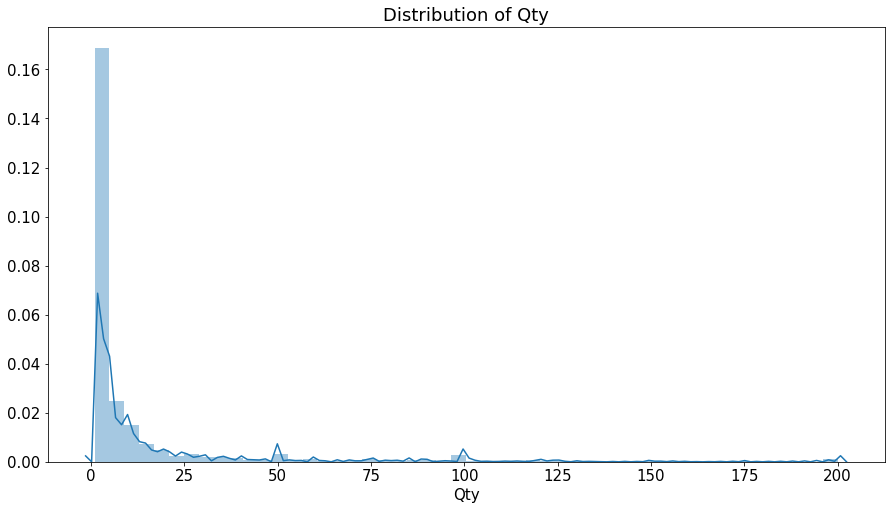

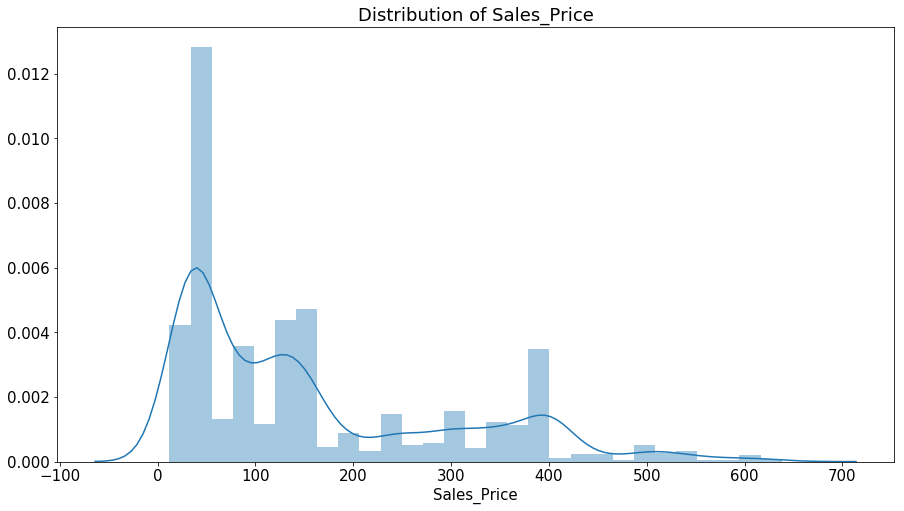

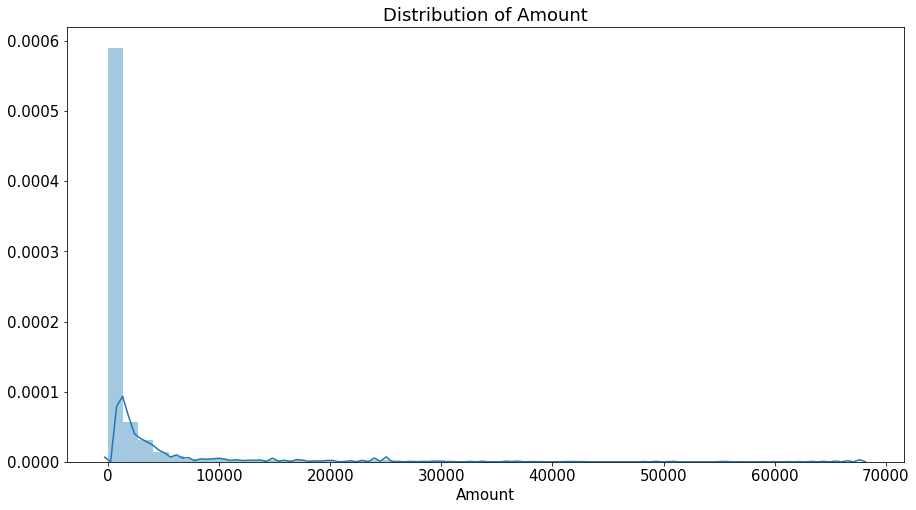

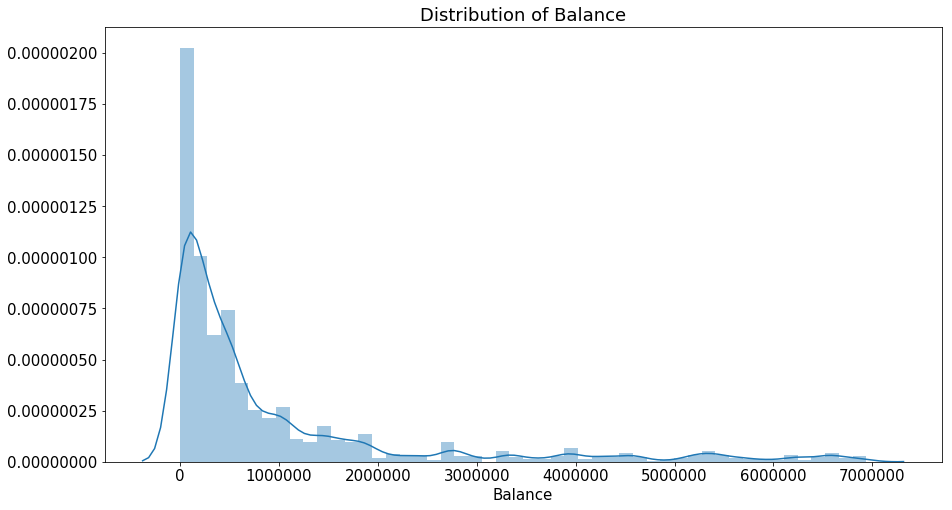

In [84]:
# Visualize distribution of our continous variables
cont_data = df_sup[['Qty','Sales_Price','Amount','Balance']].copy()
for i in cont_data.columns[:]: 
    sns.distplot(cont_data[i])
    plt.title('Distribution of {}'.format(i))
    plt.show()

Hm, these are obviously quite skewed distributions, we might try to play around with these later on in creating our supervised models.

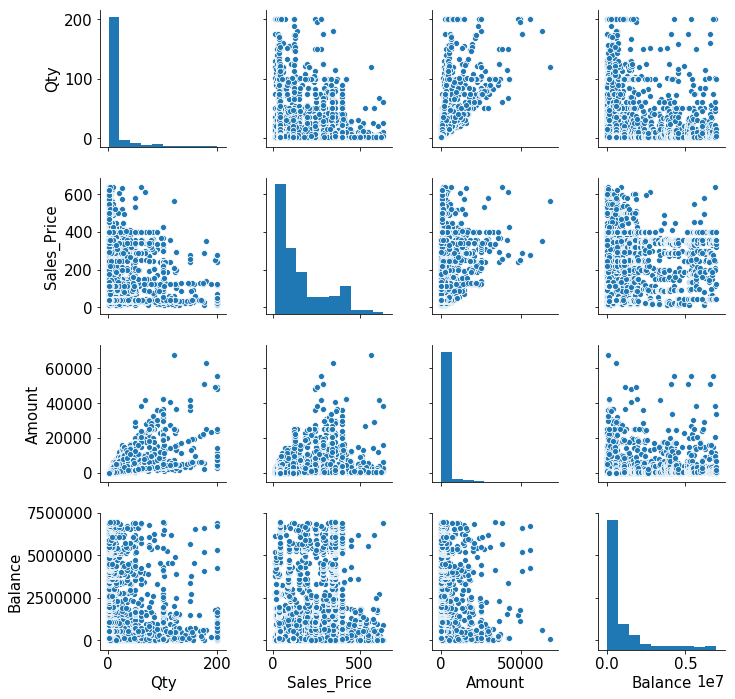

In [85]:
# Pairwise visualization of continous variables
sns.pairplot(cont_data)

In [86]:
# Check our quantile ranges for our important variables, note we are leaving out Amount as this will not be a factor in our supervised models due to its high correlation to sales price and quantity 
qty_lower_bound = df_sup.Qty.quantile(0.02)
qty_upper_bound = df_sup.Qty.quantile(0.98)

price_lower_bound = df_sup.Sales_Price.quantile(0.02)
price_upper_bound = df_sup.Sales_Price.quantile(0.98)

balance_lower_bound = df_sup.Balance.quantile(0.02)
balance_upper_bound = df_sup.Balance.quantile(0.98) 
print('Quantity purchased quantile range: less than {} and greater than {}'.format(qty_lower_bound, qty_upper_bound))
print('Price quantile range: less than {} and greater than {}'.format(price_lower_bound, price_upper_bound))
print('Balance amound quantile Range:  less than {} and greater than {}'.format(balance_lower_bound, balance_upper_bound))

Quantity purchased quantile range: less than 1.0 and greater than 102.80000000000018
Price quantile range: less than 24.0 and greater than 514.0
Balance amound quantile Range:  less than 752.0000000000002 and greater than 6235759.59


In [0]:
#Make changes to df
df_sup = df_sup[df_sup['Qty'] >= 1.0]
df_sup = df_sup[df_sup['Qty'] <= 200.0]
df_sup = df_sup[df_sup['Sales_Price'] >= 12.0]
df_sup = df_sup[df_sup['Sales_Price'] <= 638.0]
df_sup = df_sup[df_sup['Balance'] >= 299.9]
df_sup = df_sup[df_sup['Balance'] <= 6937979.34]


In [88]:
# Let's take a look at where our customers are located
# Inclusive of US Virgin Islands, Quebec, and Ontario 
customer_state=df_sup[['Name_State','Name']].drop_duplicates()
customer_state.groupby(['Name_State'])['Name'].aggregate('count').reset_index().sort_values('Name', ascending=False)

Name_State  Name
33         NY   259
5          CA   120
43         TX    55
8          DC    36
20         MD    29
30         NJ    21
45         VA    20
10         GA    20
9          FL    19
6          CO    16
27         NC    13
29         NH    12
38         PA    12
25         MS    11
1          AK    11
31         NM    10
37         OR     9
34         OH     9
40         SC     8
7          CT     8
48         WA     8
4          AZ     6
23         MN     6
44         UT     5
17         KY     5
19         MA     5
24         MO     5
0          AE     5
36         ON     4
26         MT     4
2          AL     4
22         MI     4
18         LA     3
15         IN     3
42         TN     3
3          AR     3
47         VT     2
32         NV     2
21         ME     2
35         OK     2
14         IL     2
49         WI     2
12         IA     2
11         HI     2
28         NE     1
50         WV     1
41         SD     1
46         VI     1
13         ID     1
39         QC     1
16         KS     1
51         WY     1

Looks like a majority of the customers are located in California and New York. 

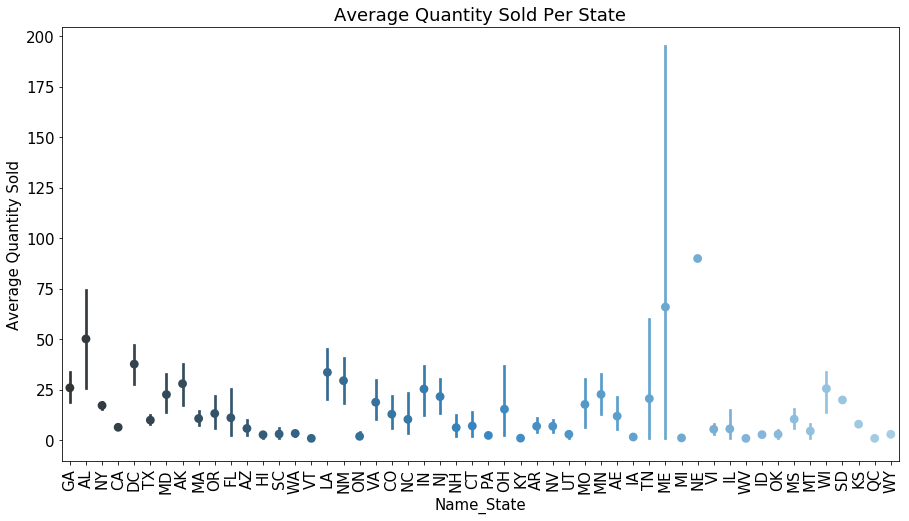

In [89]:
# Visualize quantities purchased per state 
sns.pointplot(x="Name_State", y="Qty", data=df_sup, palette='Blues_d')
plt.ylabel("Average Quantity Sold")
plt.title("Average Quantity Sold Per State")
plt.xticks(rotation=90);

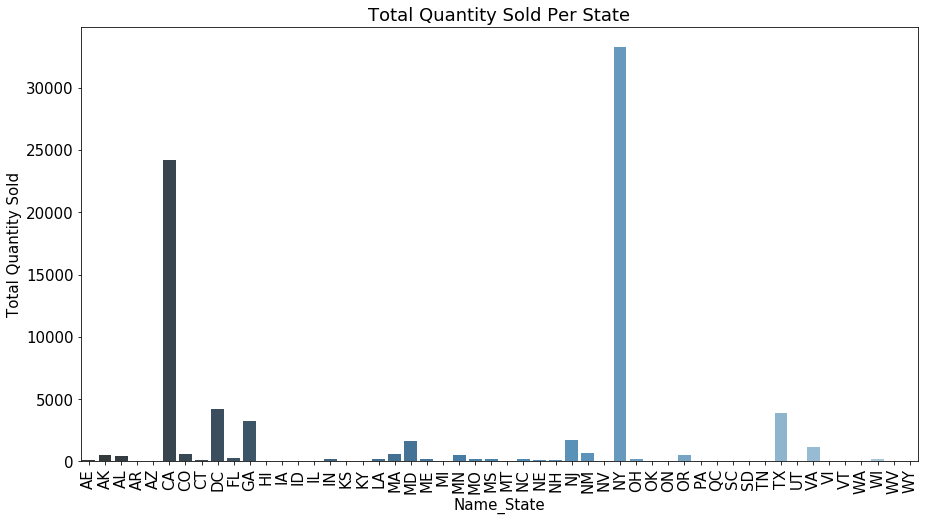

In [90]:
qty_state_sum = df_sup[['Qty', 'Name_State']].groupby('Name_State').sum().reset_index()
sns.barplot(x='Name_State',y='Qty',data=qty_state_sum, palette='Blues_d')
plt.title('')
plt.title("Total Quantity Sold Per State")
plt.xlabel('Name_State')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90);

In [91]:
# View top product per state
top_product = df_sup.groupby(['Name_State','Item'])['Qty'].sum().to_frame()
top_product = top_product.groupby('Name_State')['Qty'].nlargest(1).to_frame()
top_product

Qty
Name_State Name_State Item                                                       
AE         AE         aa e-Learn My SkillSource:CP/Telephony (Compute...     50.0
AK         AK         aa e-Learn My SkillSource:Office Pro (Office Pr...    225.0
AL         AL         Red Vector Library (RV - Library)                     247.0
AR         AR         Red Vector Library (RV - Library)                      11.0
AZ         AZ         aa e-Learn My SkillSource:Office Pro (Office Pr...     24.0
CA         CA         OTech #1 (Base - Part #2- Courses & Video  )        10281.0
CO         CO         Red Vector Library (RV - Library)                     215.0
CT         CT         aa SkillSoft:Subscription (Subscription Library)       86.0
DC         DC         Red Vector Library (RV - Library)                    3603.0
FL         FL         aa e-Learn My SkillSource:Misc. Sub. Library (S...    155.0
GA         GA         aa e-Learn My SkillSource:Office Pack (Microsof...   1028.0
HI         HI         12327 (UNIX Fundamentals - Single User)                 6.0
IA         IA         aa e-Learn My SkillSource:Computer Pro. (Comput...      5.0
ID         ID         Red Vector Library (RV - Library)                      34.0
IL         IL         aa SkillSoft:Subscription (Subscription Library)       17.0
IN         IN         Red Vector Library (RV - Library)                     177.0
KS         KS         Red Vector Library (RV - Library)                       8.0
KY         KY         Elementkpress (Books)                                  42.0
LA         LA         DWOffcePk (MS Office 97 Suite - 5 titles on 2 C...    175.0
MA         MA         aa SkillSoft:Subscription (Subscription Library)      220.0
MD         MD         Red Vector Library (RV - Library)                    1351.0
ME         ME         Red Vector Library (RV - Library)                     195.0
MI         MI         aa NETg:Perpetual (Perpetual License)                   7.0
MN         MN         Red Vector Library (RV - Library)                     521.0
MO         MO         aa e-Learn My SkillSource:Computer Pro. (Comput...    117.0
MS         MS         Red Vector Library (RV - Library)                     210.0
MT         MT         Red Vector Library (RV - Library)                      13.0
NC         NC         aa e-Learn My SkillSource:Office Pro (Office Pr...    120.0
NE         NE         aa e-Learn My SkillSource:Business Performance ...     90.0
NH         NH         aa e-Learn My SkillSource:Office Pro (Office Pr...     69.0
NJ         NJ         Red Vector Library (RV - Library)                     949.0
NM         NM         Red Vector Library (RV - Library)                     368.0
NV         NV         aa e-Learn My SkillSource:Project Management (P...     10.0
NY         NY         aa SkillSoft:Subscription (Subscription Library)    16411.0
OH         OH         Red Vector Library (RV - Library)                     162.0
OK         OK         Red Vector Library (RV - Library)                       9.0
ON         ON         aa e-Learn My SkillSource:Misc. Sub. Library (S...     10.0
OR         OR         aa e-Learn My SkillSource:Office Pro (Office Pr...    282.0
PA         PA         Red Vector Library (RV - Library)                      34.0
QC         QC         aa SkillSoft:Subscription (Subscription Library)        1.0
SC         SC         Red Vector Library (RV - Library)                      13.0
SD         SD         Red Vector Library (RV - Library)                      20.0
TN         TN         Red Vector Library (RV - Library)                      61.0
TX         TX         aa SkillSoft:Subscription (Subscription Library)     1736.0
UT         UT         Red Vector Library (RV - Library)                      13.0
VA         VA         DWOffcePk (MS Office 97 Suite - 5 titles on 2 C...    360.0
VI         VI         aa e-Learn My SkillSource:Project Management (P...      8.0
VT         VT         Shipping                              

Wow, seems like Red Vector is quite popular amongst most of our locations. 

In [92]:
df_sup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7061 entries, 567 to 8204
Data columns (total 13 columns):
Type            7061 non-null object
Date            7061 non-null datetime64[ns]
Name_State      7061 non-null object
Name            7061 non-null int64
Item            7061 non-null object
Account         7061 non-null object
Class           7061 non-null object
Rep             7061 non-null object
Qty             7061 non-null float64
Sales_Price     7061 non-null float64
Amount          7061 non-null float64
Balance         7061 non-null float64
Account_Type    7061 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(7)
memory usage: 1.1+ MB


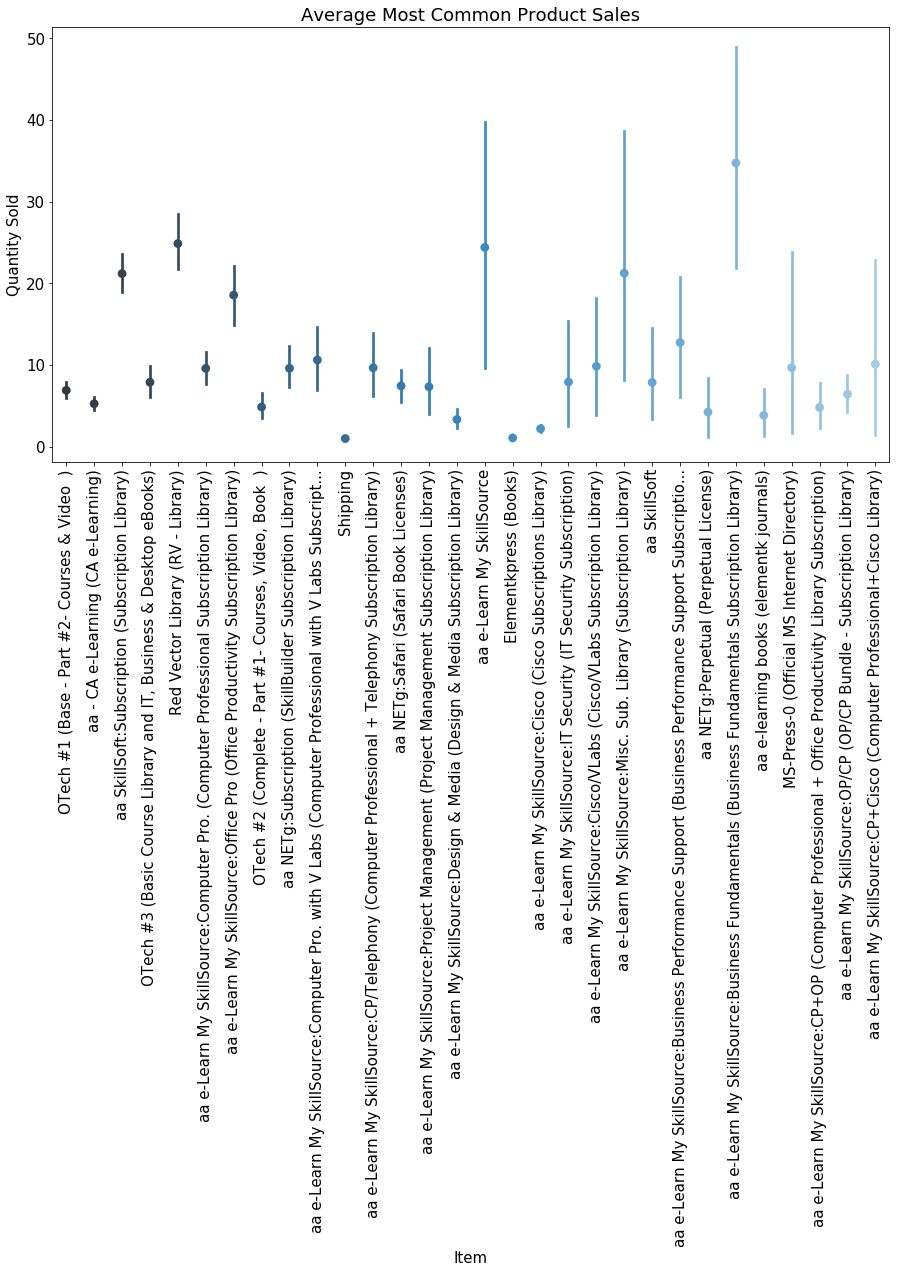

In [198]:
sns.pointplot(x="Item", y="Qty", data=df_sup,order=df_sup.Item.value_counts().iloc[:30].index,palette='Blues_d')
plt.ylabel("Quantity Sold")
plt.title("Average Most Common Product Sales")
plt.xticks(rotation=90);

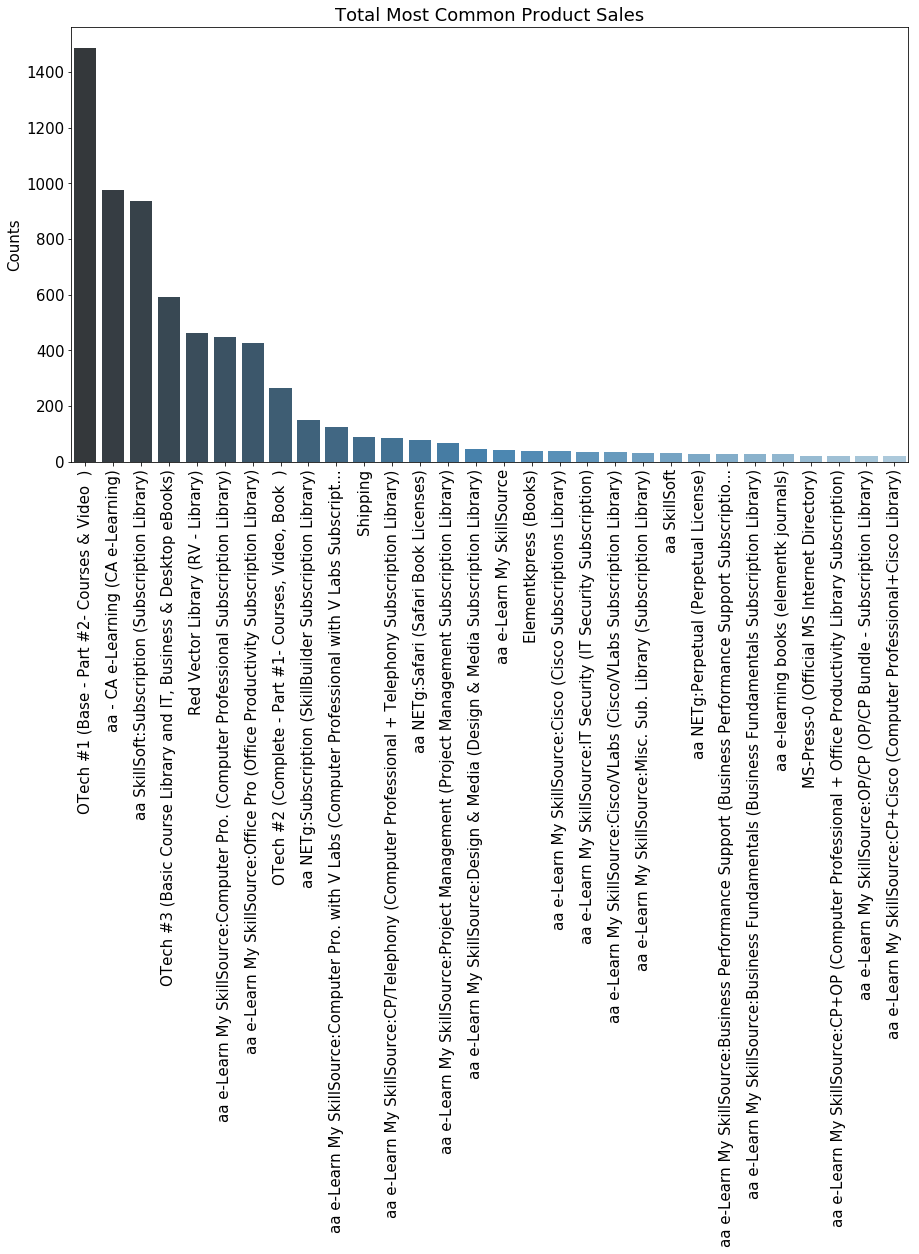

In [94]:
# Visualize most commonly purchased products 
Item_counts = df_sup.Item.value_counts().sort_values(ascending=False).iloc[0:30]
sns.barplot(Item_counts.index, Item_counts.values, palette='Blues_d')
plt.ylabel("Counts")
plt.title("Total Most Common Product Sales")
plt.xticks(rotation=90);

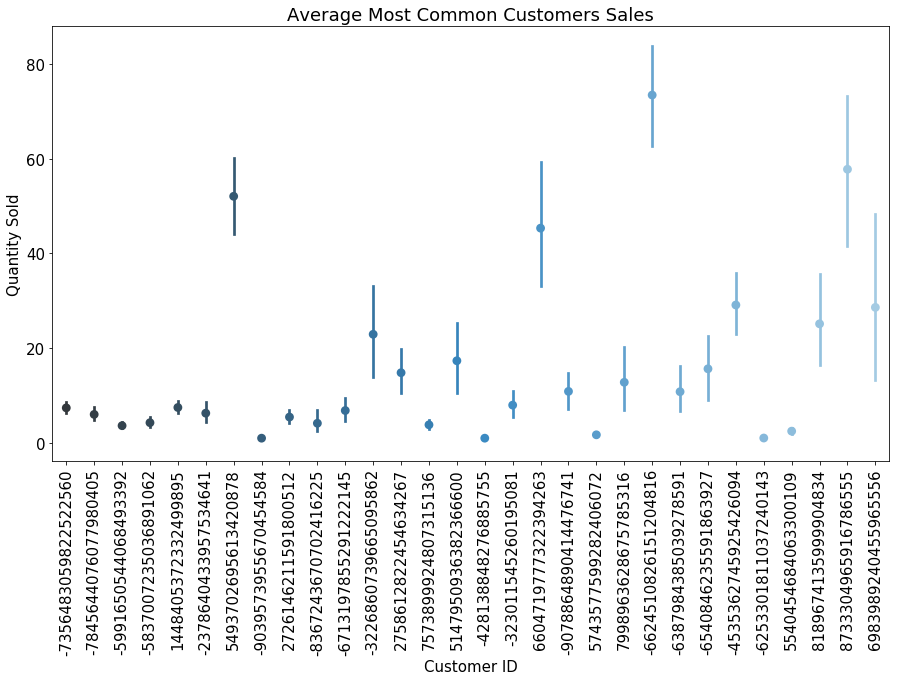

In [113]:
sns.pointplot(x="Name", y="Qty", data=df_sup,order=df_sup.Name.value_counts().iloc[:30].index, palette='Blues_d')
plt.ylabel("Quantity Sold")
plt.xlabel('Customer ID')
plt.title("Average Most Common Customers Sales")
plt.xticks(rotation=90);

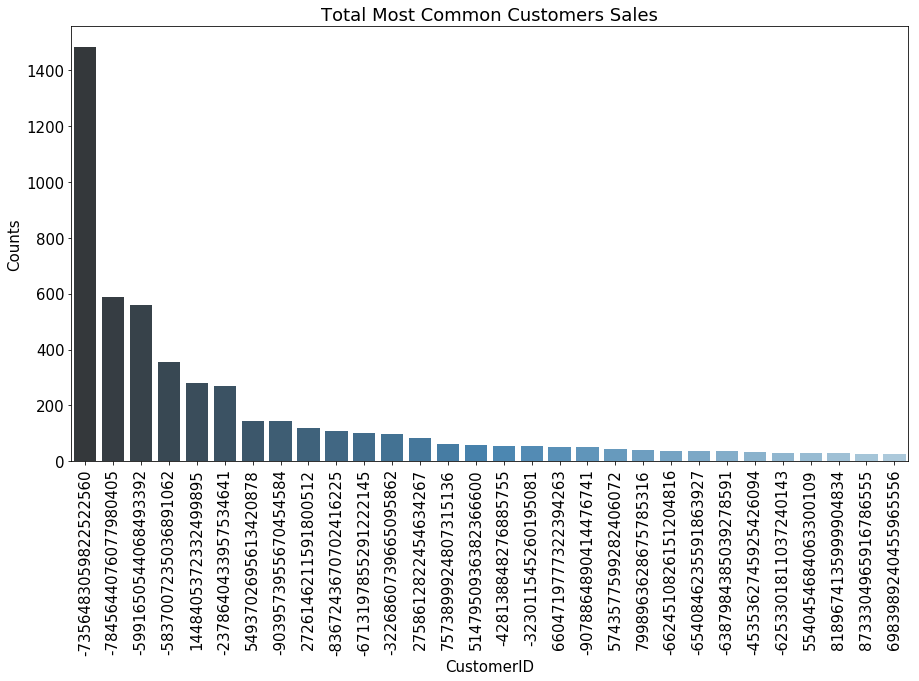

In [96]:
customer_counts = df_sup.Name.value_counts().sort_values(ascending=False).iloc[0:30] 
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index, palette='Blues_d')
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Total Most Common Customers Sales");
plt.xticks(rotation=90);

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

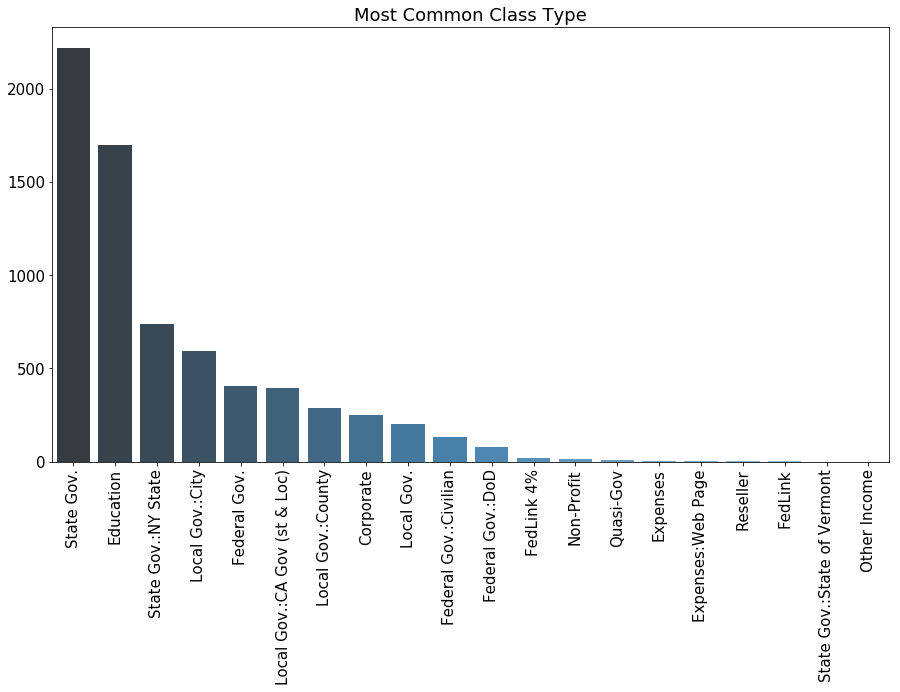

In [97]:
Class_counts = df_sup.Class.value_counts().sort_values(ascending=False).iloc[0:30]
sns.barplot(Class_counts.index, Class_counts.values, palette='Blues_d')
plt.title('')
plt.title("Most Common Class Type")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

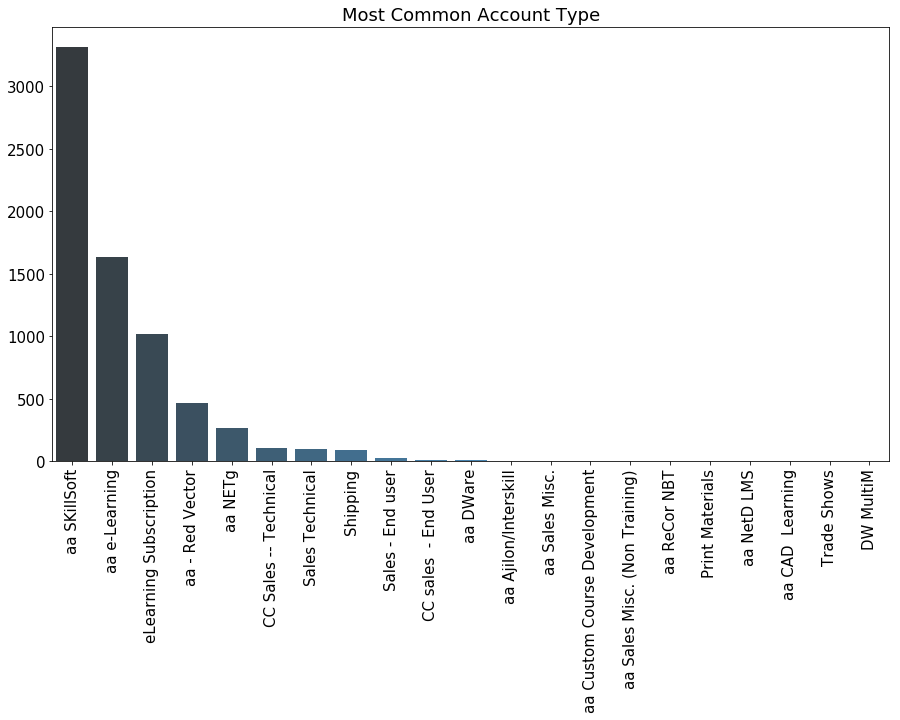

In [98]:
Account_counts = df_sup.Account.value_counts().sort_values(ascending=False).iloc[0:30]
sns.barplot(Account_counts.index, Account_counts.values, palette='Blues_d')
plt.title('')
plt.title("Most Common Account Type");
plt.xticks(rotation=90)

In [80]:
rep_count = df_sup.groupby(['Rep'])['Qty'].aggregate('count').reset_index().sort_values('Qty', ascending=False)
rep_count

Rep   Qty
8    MV  4001
5    KG  1913
4    JR   611
7    MD   284
12   SF   148
3    JD    45
9    OB    29
11   SC    12
0    DB     5
6    KS     5
10   RH     3
1    EP     2
2   HSE     2
13   WS     1

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

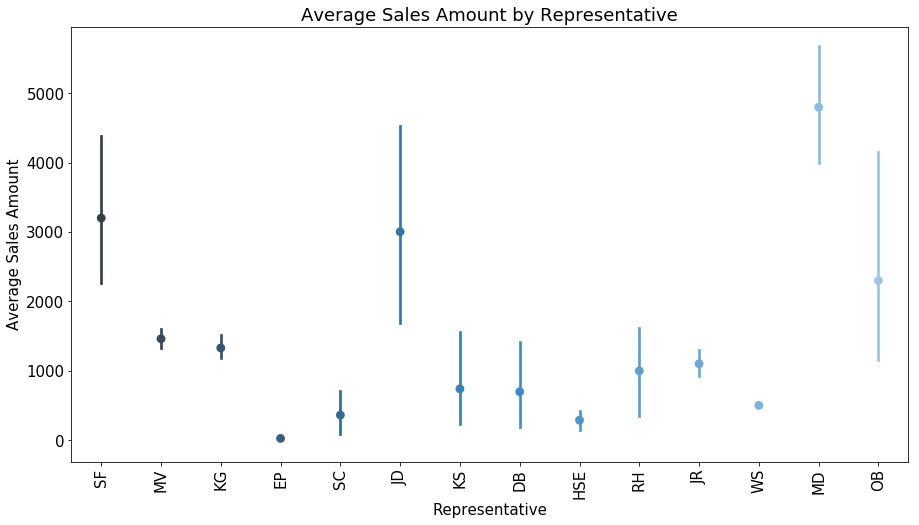

In [81]:
sns.pointplot(x='Rep',y='Amount',data=df_sup,palette='Blues_d')
plt.title('')
plt.title("Average Sales Amount by Representative")
plt.xlabel('Representative')
plt.ylabel('Average Sales Amount')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

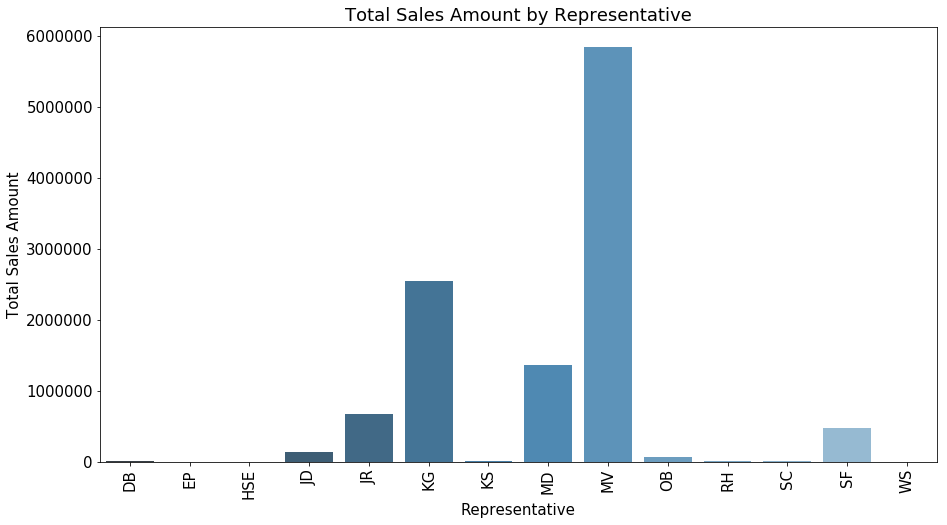

In [82]:
amt_rep_sum = df_sup[['Amount', 'Rep']].groupby('Rep').sum().reset_index()

sns.barplot(x='Rep',y='Amount',data=amt_rep_sum,palette='Blues_d')
plt.title('')
plt.title("Total Sales Amount by Representative")
plt.xlabel('Representative')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=90)

# Time Series

## Time Series Model #1: Monthly Prediction

In [0]:
# Make another copy of the df for our time series modeling and visualizations 
df_time = df.copy()

In [0]:
# For Continuity, we'll have to remove negative value points from Sales Price that also indicate return values
df_time.loc[:, ['Sales_Price']].fillna(0, inplace=True)
df_time['Sales_Price'] = pd.to_numeric(df_time['Sales_Price'],errors='coerce')
df_time = df_time[(df_time.Sales_Price > 0)]
df_time["Qty"] = pd.to_numeric(df_time["Qty"], errors='coerce')

In [0]:
df_time['Date']=pd.to_datetime(df_time['Date'])
df_time.sort_values(by=['Date'], inplace=True, ascending=True)

In [40]:
print("Datafile starts with timepoint {}".format(df_time.Date.min()))
print("Datafile ends with timepoint {}".format(df_time.Date.max()))

Datafile starts with timepoint 1997-07-01 00:00:00
Datafile ends with timepoint 2018-12-30 00:00:00


In [41]:
df_time = df_time.set_index('Date')
df_time.index

DatetimeIndex(['1997-07-01', '1997-07-01', '1997-07-01', '1997-07-01',
               '1997-07-01', '1997-07-01', '1997-07-01', '1997-07-01',
               '1997-07-01', '1997-07-01',
               ...
               '2018-12-13', '2018-12-18', '2018-12-18', '2018-12-18',
               '2018-12-19', '2018-12-20', '2018-12-20', '2018-12-20',
               '2018-12-20', '2018-12-30'],
              dtype='datetime64[ns]', name='Date', length=8270, freq=None)

In [0]:
# We'll re-group by month 
y = df_time['Qty'].resample('MS').mean()

In [45]:
y['2018':]

Date
2018-01-01    26.102564
2018-02-01    18.550000
2018-03-01    62.746269
2018-04-01    10.843137
2018-05-01    19.480000
2018-06-01    19.255814
2018-07-01     9.058824
2018-08-01    51.121951
2018-09-01    20.600000
2018-10-01    17.574074
2018-11-01     6.058824
2018-12-01     4.722222
Freq: MS, Name: Qty, dtype: float64

In [298]:
y.describe()

count    258.000000
mean      19.232986
std       21.365284
min        1.000000
25%        5.119253
50%       13.226562
75%       24.988575
max      127.812500
Name: Qty, dtype: float64

In [299]:
y.isnull().sum()

0

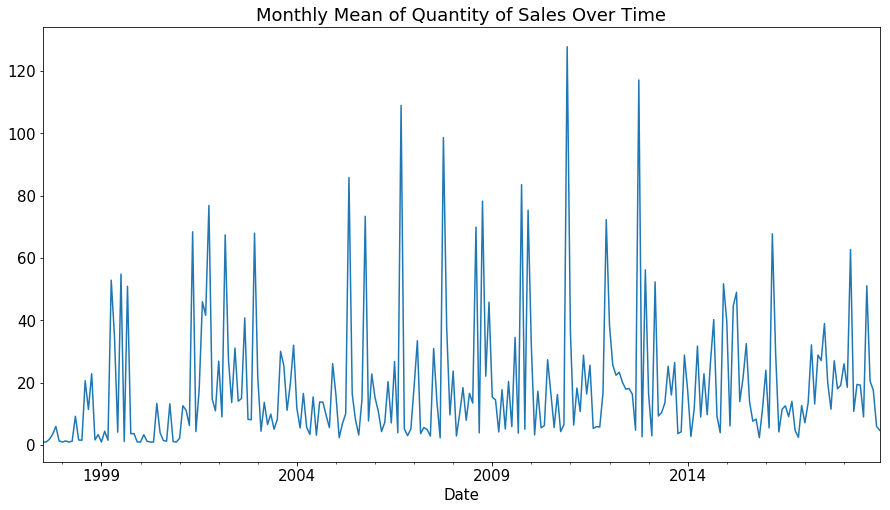

In [300]:
# Visualize our target variable
y.plot()
plt.title("Monthly Mean of Quantity of Sales Over Time");

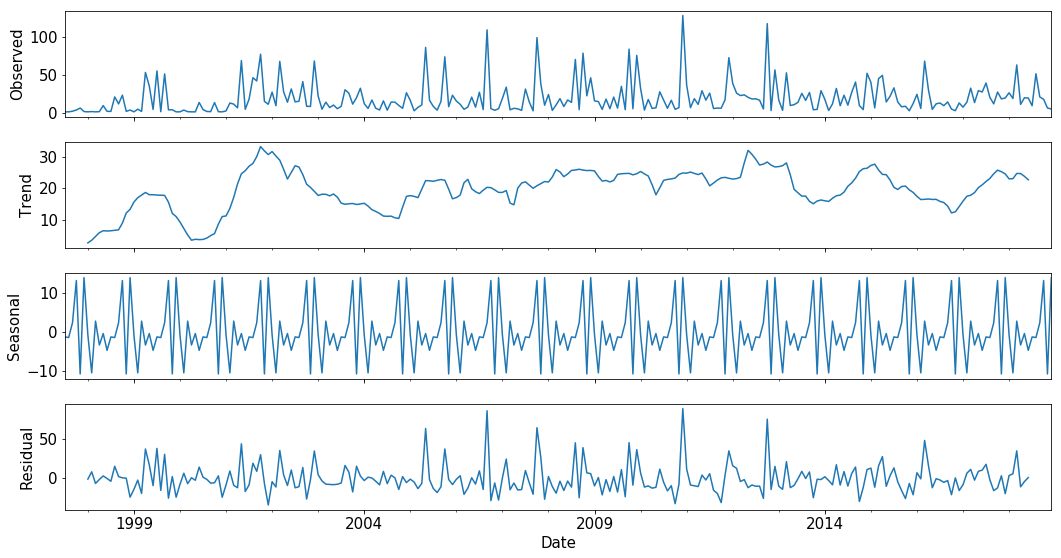

In [301]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

After looking at the above plots, we can definitely spot both trend and seasonality in the data. The Trend showcases the overall direction in which the data is moving over time, as the Seasonal aspect will depict repeating patterns over time. 

Going forward in the study we wi'll use the SARIMAX model (Seasonal Autoregressive Integrated Moving Average), which better accounts for seasonality than that of the ARIMA model by adding additional hyperparameters to account for the period of seasonality. 

In [0]:
# We'll first loop through PDQ values for our model to determine the best AIC value and best suited model. 
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [303]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2458.064456909776
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2302.573673874455
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2314.847322036385
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2104.5863324367856
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2270.431167342765
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2216.918482796
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2161.3481913365395
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2106.552515708823
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2421.3749120740354
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2283.448473275447
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2306.652432806064
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2097.9536495935317
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2271.3166106892563
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2210.308315319558
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2161.8823245497124
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2099.9112186839056
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2481.1108474261846
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2371.4434865675616
ARIM

The Akaike Information Criterion (AIC) measures distance between the model and the truth, thus when choosing a model the lower the value the better. Looks like the lowest AIC value comes from ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:2101.9853824055253. 

In [0]:
# Let's split our data to train and test, reserving approximately 20% for the test  
train = y.loc['1997-07-01':'2014-12-01']
test = y.loc['2015-01-01':]

In [305]:
mod1 = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results1 = mod1.fit()
print(results1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2592      1.149     -0.226      0.822      -2.511       1.993
ma.L1          0.2059      1.168      0.176      0.860      -2.084       2.496
ar.S.L12       0.0025      0.067      0.038      0.970      -0.128       0.133
ma.S.L12      -0.8266      0.057    -14.396      0.000      -0.939      -0.714
sigma2       512.0762     33.118     15.462      0.000     447.166     576.987


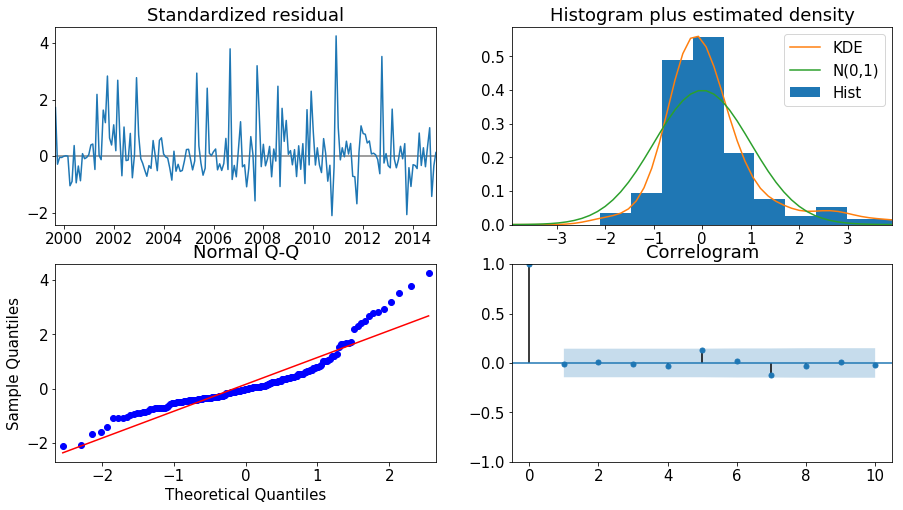

In [306]:
results1.plot_diagnostics()
plt.show()

Though our residuals look random and normally distributed, not all of our P values are statistically significant. Therefore, we'll try our second lowest AIC value, ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2104.5863324367856. 

In [307]:
mod2 = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.8299      0.040    -20.853      0.000      -0.908      -0.752
sigma2       511.2685     30.522     16.751      0.000     451.447     571.090


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


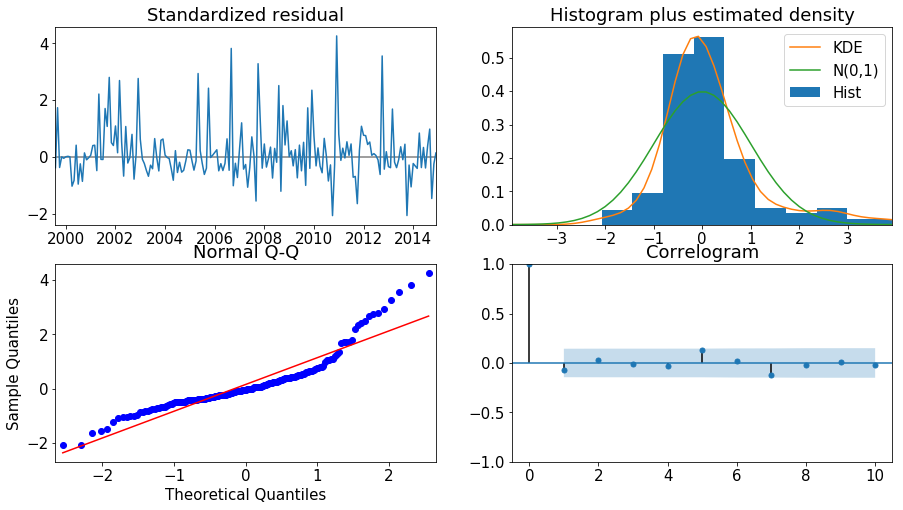

In [308]:
results2.plot_diagnostics()
plt.show()

Our residuals look pretty good wit this model, and our P values all appear to be below .05! 

In [309]:
# We'll now predict our sales and compare against the observed values. 
predict = results2.predict(start='2014-12-01', end='2018-12-01', dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


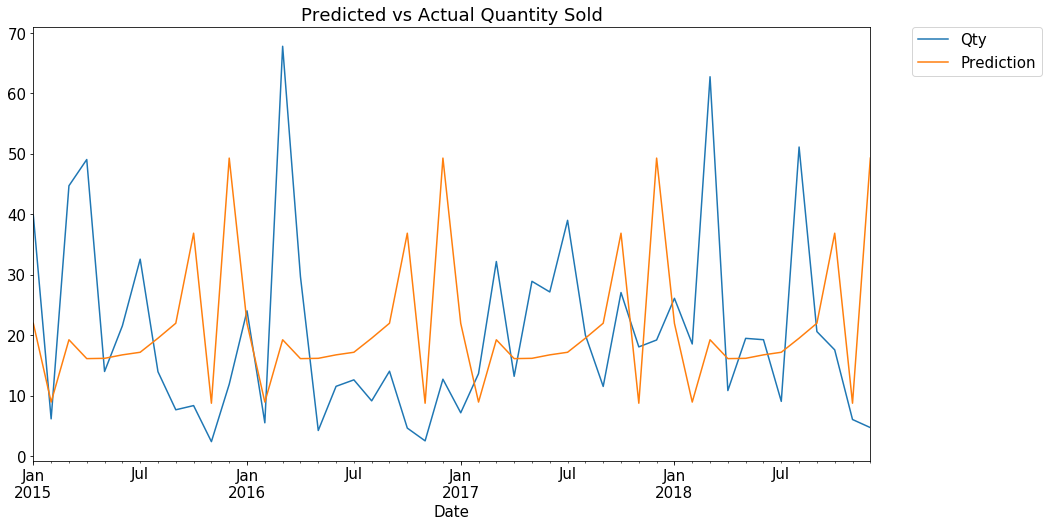

In [310]:
# Plotting only the predicted values  
future_forecast = pd.DataFrame(predict,index = test.index,columns=['Prediction'])

pd.concat([test,future_forecast],axis=1).plot()
plt.title("Predicted vs Actual Quantity Sold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

RMSE: 3.7986807331779495


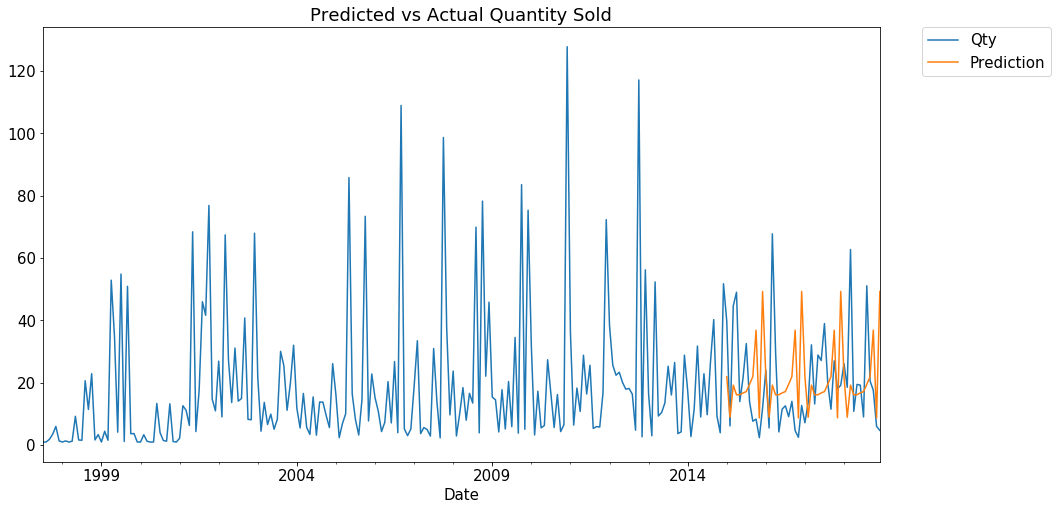

In [311]:
# Plotting against the full dataset 
pd.concat([y,future_forecast],axis=1).plot()
plt.title("Predicted vs Actual Quantity Sold");
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
print('RMSE:',np.sqrt(metrics.mean_absolute_error(test,future_forecast)))

This tells us that our model was able to forecast the average montly sales in the test set within 3 of the actual observed sales value. 

In [312]:
# Fit to full dataset 
mod_final = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_final = mod_final.fit()
print(results_final.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.8001      0.036    -22.512      0.000      -0.870      -0.730
sigma2       468.9149     25.224     18.590      0.000     419.477     518.353


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [314]:
# We'll now predict our future sales 
predict_final = results_final.predict(start = '2019-1-01', end = '2019-12-01', dynamic=False)
predict_final

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


2019-01-01    22.764310
2019-02-01    10.856502
2019-03-01    39.168798
2019-04-01    19.947437
2019-05-01    16.834987
2019-06-01    18.944051
2019-07-01    20.060829
2019-08-01    24.076791
2019-09-01    17.575032
2019-10-01    24.173438
2019-11-01     8.111613
2019-12-01    27.791578
Freq: MS, dtype: float64

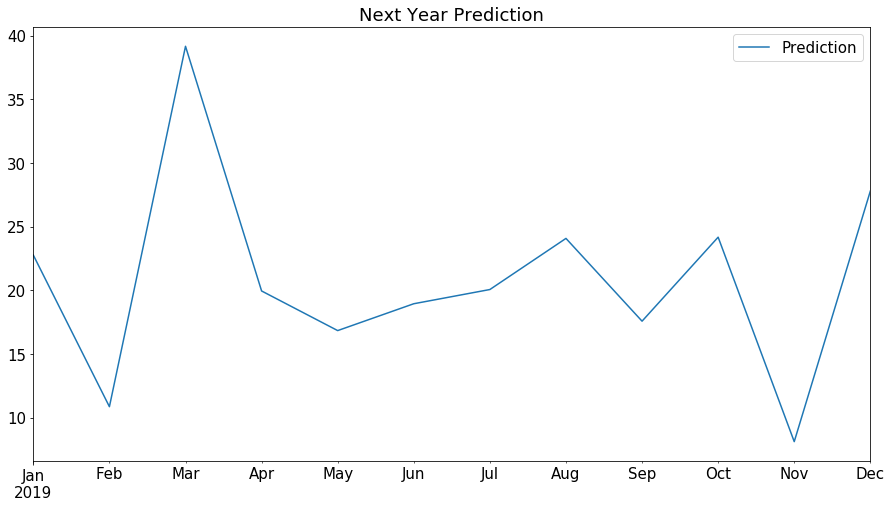

In [315]:
# Plotting only the predicted values  
future_forecast_final = pd.DataFrame(predict_final,columns=['Prediction'])

future_forecast_final.plot()
plt.title("Next Year Prediction");

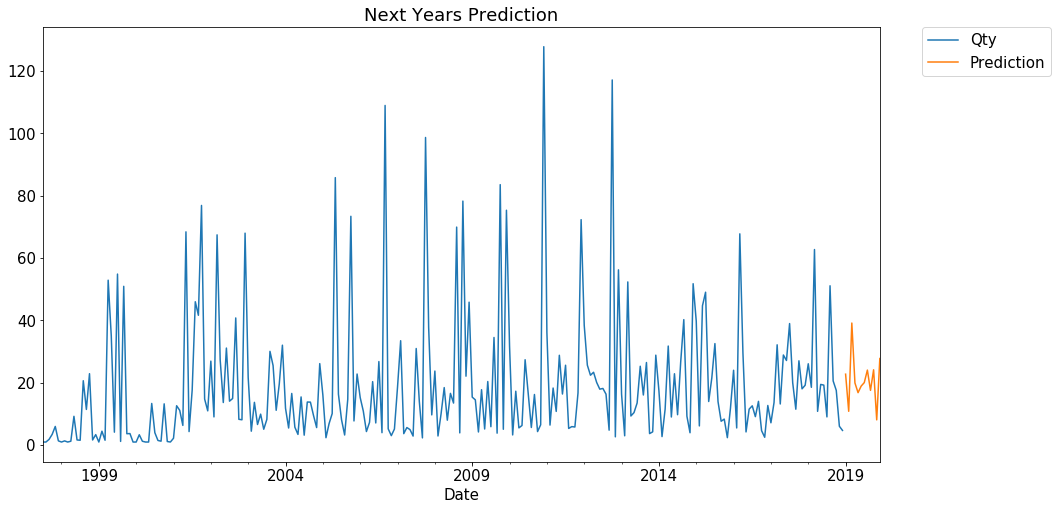

In [316]:
# Plotting against the full dataset 
pd.concat([y,future_forecast_final],axis=1).plot()
plt.title("Next Years Prediction");
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Time Series Model #2: Daily Prediction

In [0]:
y2 = df_time['Qty'].resample('D').mean()
y2 = y2.fillna(0)

In [44]:
y2['2018':]

Date
2018-01-01      0.000000
2018-01-02      4.000000
2018-01-03      6.500000
2018-01-04      0.000000
2018-01-05     15.000000
2018-01-06      0.000000
2018-01-07      0.000000
2018-01-08      1.500000
2018-01-09      4.000000
2018-01-10      0.000000
2018-01-11     11.000000
2018-01-12      0.000000
2018-01-13      0.000000
2018-01-14      0.000000
2018-01-15      1.000000
2018-01-16      1.000000
2018-01-17      0.000000
2018-01-18     15.800000
2018-01-19      9.000000
2018-01-20      0.000000
2018-01-21      0.000000
2018-01-22      1.000000
2018-01-23      0.000000
2018-01-24      2.666667
2018-01-25    197.750000
2018-01-26      0.000000
2018-01-27      0.000000
2018-01-28      0.000000
2018-01-29      1.000000
2018-01-30      1.000000
                 ...    
2018-12-01      0.000000
2018-12-02      0.000000
2018-12-03      1.600000
2018-12-04      2.750000
2018-12-05      1.000000
2018-12-06     11.500000
2018-12-07      0.000000
2018-12-08      0.000000
2018-12-09      0.00

In [45]:
y2.describe()

count    7853.000000
mean        5.646855
std        30.089817
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       765.000000
Name: Qty, dtype: float64

In [46]:
y2.isnull().sum()

0

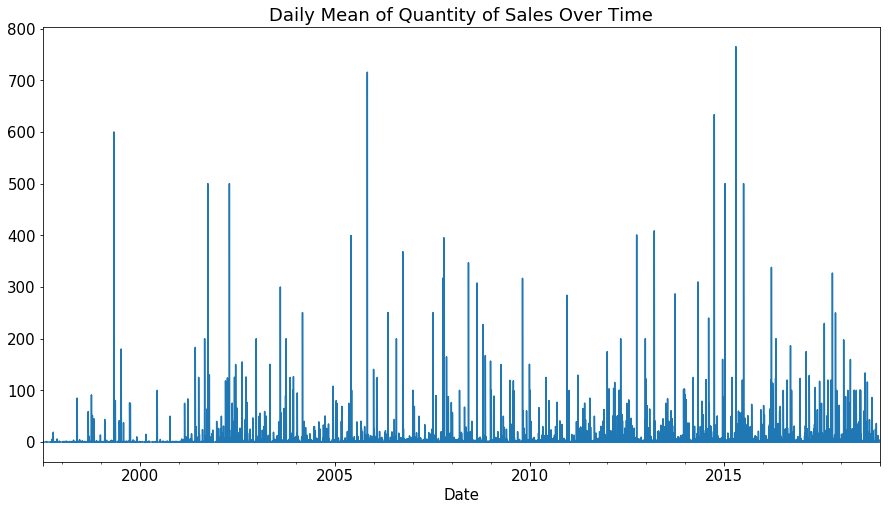

In [49]:
# Visualize our target variable
y2.plot()
plt.title("Daily Mean of Quantity of Sales Over Time");
plt.show()

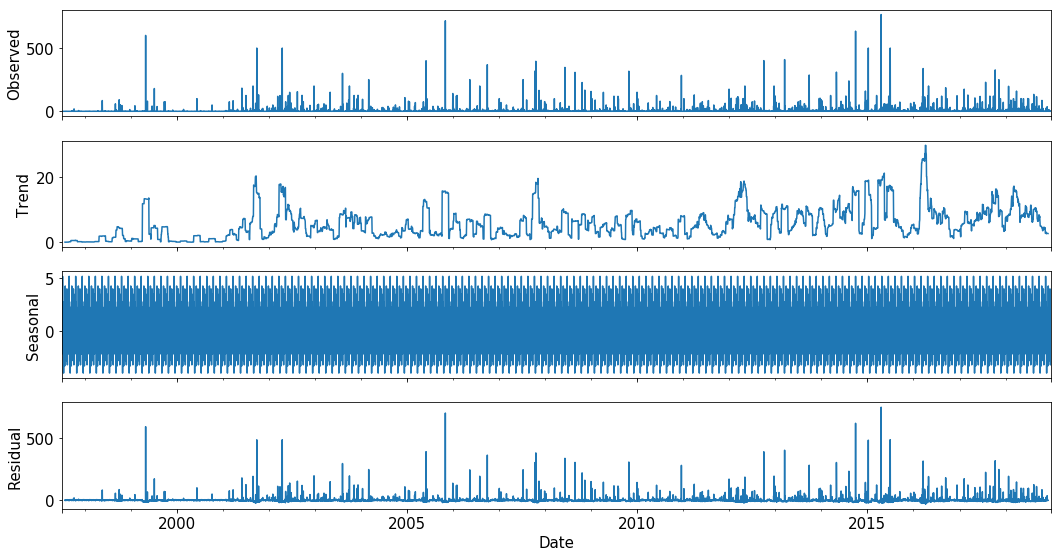

In [50]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y2, model='additive', freq=52)
fig = decomposition.plot()
plt.show()

Unfortunately, SARIMAX is not well-suited to large seasonal patterns and setting m=365 would take a lot of memory and computation time.

In [0]:
# We'll first loop through PDQ values for our model to determine the best AIC value and best suited model. 
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [0]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:76016.17279628738
ARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC:75562.26934402366
ARIMA(0, 0, 0)x(0, 1, 0, 52) - AIC:80776.8849339884


Even setting the weekly seasonality parameter to 52, our memory gets full and the loop can't quite complete. Instead, we'll use the same parameters used in the previous SARIMAX model to see how it fares. 

In [0]:
# Let's split our data to train and test, reserving approximately 20% for the test  
train = y2.loc['1997-07-01':'2014-12-01']
test = y2.loc['2015-01-01':]

In [53]:
mod1 = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results1 = mod1.fit()
print(results1.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.9853      0.004   -269.575      0.000      -0.992      -0.978
sigma2       805.4867      1.704    472.740      0.000     802.147     808.826


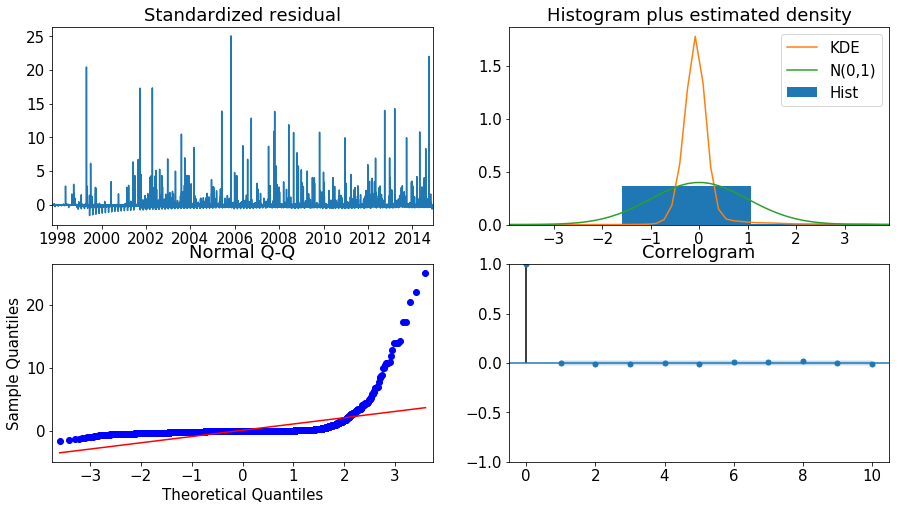

In [54]:
results1.plot_diagnostics()
plt.show()

In [55]:
# We'll now predict our sales and compare against the observed values. 
predict = results1.predict(start='2014-12-01', end='2018-12-30', dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


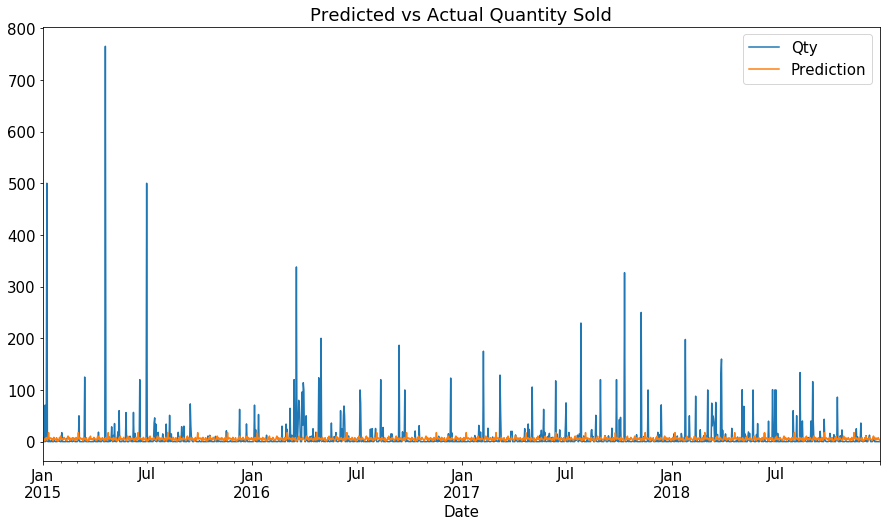

In [56]:
# Plotting only the predicted values  
future_forecast = pd.DataFrame(predict,index = test.index,columns=['Prediction'])

pd.concat([test,future_forecast],axis=1).plot()
plt.title("Predicted vs Actual Quantity Sold");

RMSE: 3.39238159410763


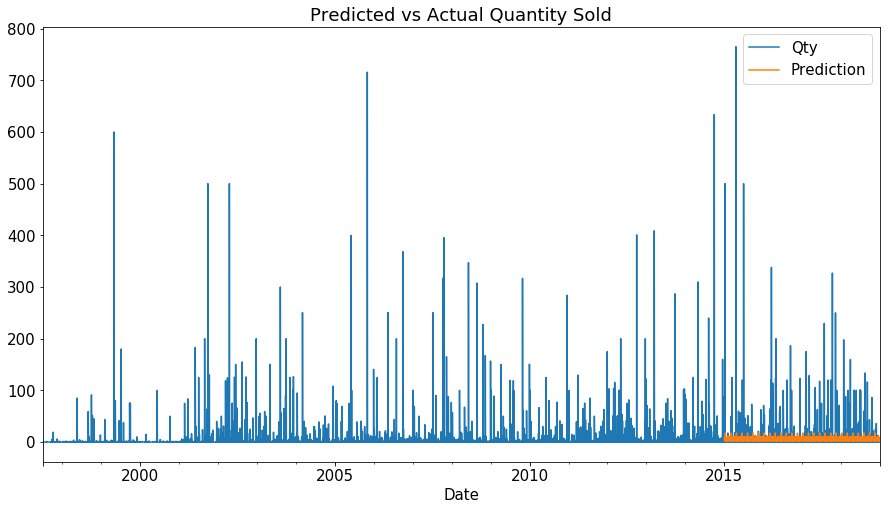

In [57]:
# Plotting against the full dataset 
pd.concat([y2,future_forecast],axis=1).plot()
plt.title("Predicted vs Actual Quantity Sold");


print('RMSE:',np.sqrt(metrics.mean_absolute_error(test,future_forecast)))

This is quite obviously not what we're looking for in a model. Depsite the minimal RMSE amounting to *** it clearly doesn't attempt to match the spikes in sales and instead goes along an average. 

# LSTM

Also known as Long Short Term Memory, these models learn from the series of past observations to predict the next value in the sequence. The recurrent neural network 'family' when  making decisiosn, will takes into acoount the current input as well as what it  learned from the previous inputs. However, the LSTM model avoids the vanishing gradient problem, which essentially is when after a number of layers are created, the memory of the earlier layers in the model begin to vanish. 

## LSTM Model #1: Monthly Prediction

We'll firstly attempt an LSTM model solely using the average quantity of sales and the date time index as done in the previous SARIMAX modeling to compare results. 

In [0]:
y = y.reset_index()
y.head()

Date       Qty
0 1997-07-01  1.000000
1 1997-08-01  1.000000
2 1997-09-01  1.839506
3 1997-10-01  3.454545
4 1997-11-01  6.000000

In [0]:
y = y.set_index(['Date'])
y.head(10)

Qty
Date                
1997-07-01  1.000000
1997-08-01  1.000000
1997-09-01  1.839506
1997-10-01  3.454545
1997-11-01  6.000000
1997-12-01  1.375000
1998-01-01  1.000000
1998-02-01  1.363636
1998-03-01  1.000000
1998-04-01  1.258065

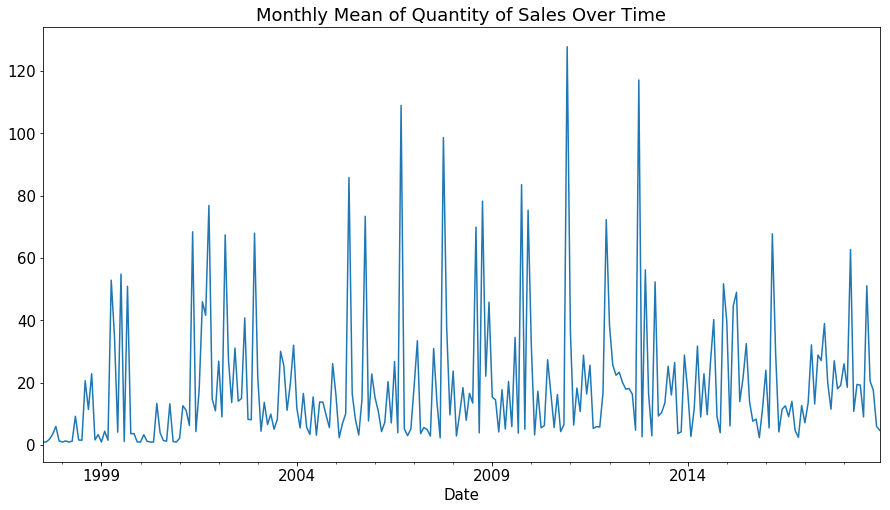

In [0]:
# Visualizing our target variable 
y['Qty'].plot()
plt.title("Monthly Mean of Quantity of Sales Over Time");


In [0]:
# Scaling the features 
values = y['Qty'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [0]:
# Again reserving 20% for the test set 
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

206 52


In [0]:
# Converts array of values to dataset matrix 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [0]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

205
51


In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
history = model.fit(trainX, trainY,epochs=300,batch_size=100,validation_data=(testX, testY),verbose=0,shuffle=False)

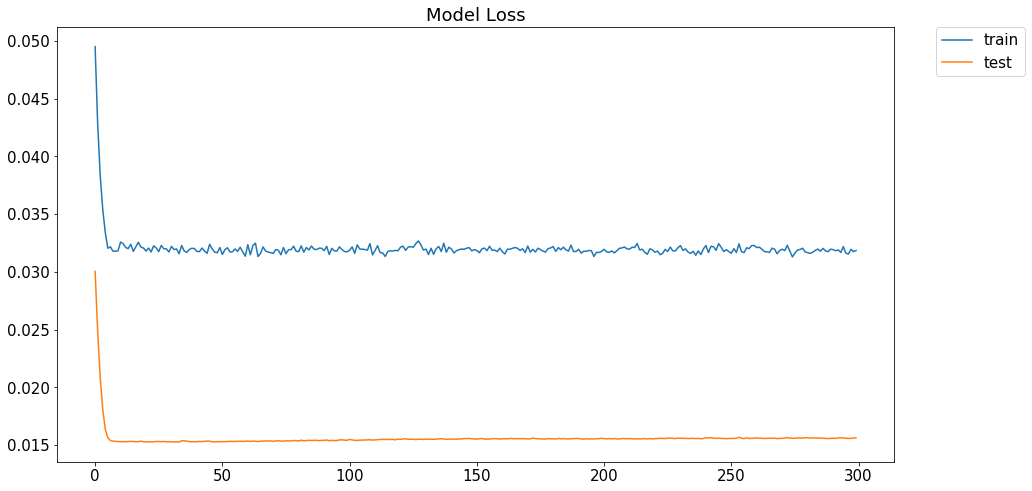

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.legend(['train', 'test'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The graphic above is showcasing Loss or the error over the training set in terms of mean squared error.

In [0]:
from datetime import datetime
test_dates=np.array(y.index)[train_size:len(y)-1]
test_dates[:10]

array(['2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [0]:
len(pd.to_datetime(test_dates).to_pydatetime())

51

In [0]:
# make a prediction
yhat = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))

In [0]:
# Invert scaling for forecast
inv_yhat = concatenate((yhat, testX[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Invert scaling for actual
testY = testY.reshape((len(testY), 1))
inv_y = concatenate((testY, testX[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)

RMSE: 15.858


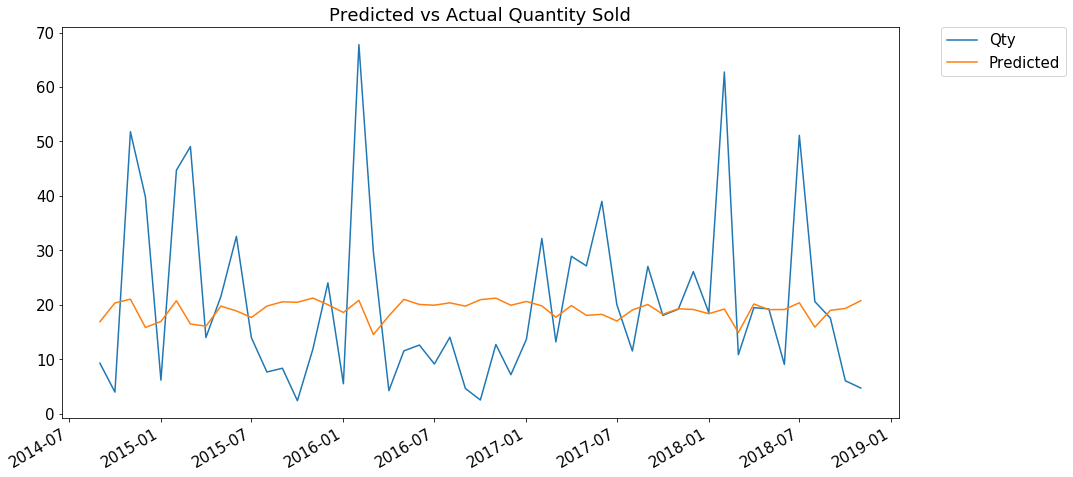

In [0]:
# Plot predictions
fig, ax = plt.subplots(1)
ax.plot(pd.to_datetime(test_dates).to_pydatetime(),inv_y, label="Qty",zorder=1)
ax.plot(pd.to_datetime(test_dates).to_pydatetime(),inv_yhat,label="Predicted",zorder=2)
fig.autofmt_xdate()
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title('Predicted vs Actual Quantity Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

It seems our LSTM model doesn't quite stack up to the daily SARIMAX model. Perhaps this is due to the minimal amount of data fed into the model given the prediction is on a per month basis.  

## LSTM Model #2: Daily Prediction

In [58]:
y2 = y2.reset_index()
y2.head()

Date  Qty
0 1997-07-01  1.0
1 1997-07-02  0.0
2 1997-07-03  0.0
3 1997-07-04  0.0
4 1997-07-05  0.0

In [59]:
y2 = y2.set_index(['Date'])
y2.head(10)

Qty
Date           
1997-07-01  1.0
1997-07-02  0.0
1997-07-03  0.0
1997-07-04  0.0
1997-07-05  0.0
1997-07-06  0.0
1997-07-07  0.0
1997-07-08  0.0
1997-07-09  0.0
1997-07-10  0.0

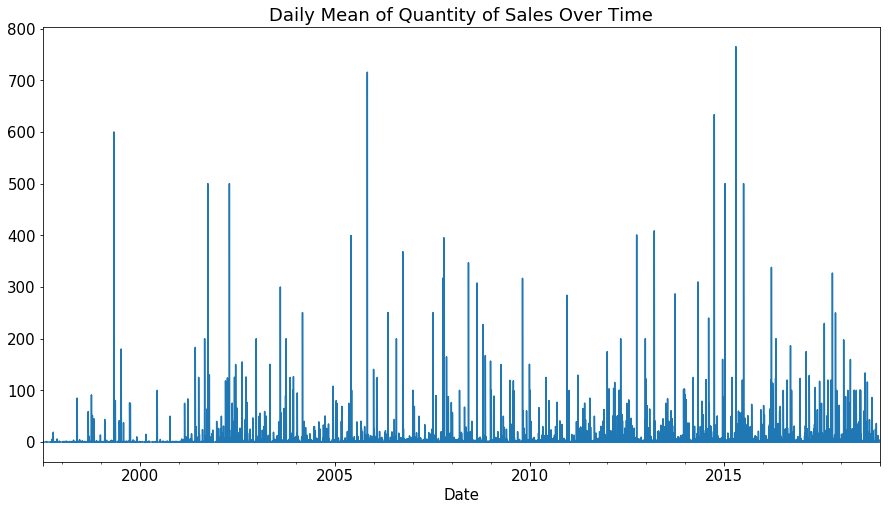

In [63]:
# Visualizing our target variable 
y2['Qty'].plot()
plt.title("Daily Mean of Quantity of Sales Over Time");

In [0]:
# Scaling the features 
values = y2['Qty'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [65]:
# Again reserving 20% for the test set 
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

6282 1571


In [68]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

6281
1570


In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [70]:
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN
from keras import optimizers
rmsprop = optimizers.rmsprop(lr=.0001)
model.compile(optimizer= rmsprop, loss='mean_squared_error')
# Fitting to the training set
history = model.fit(trainX, trainY,epochs=300,batch_size=500,validation_data=(testX, testY),verbose=0,shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


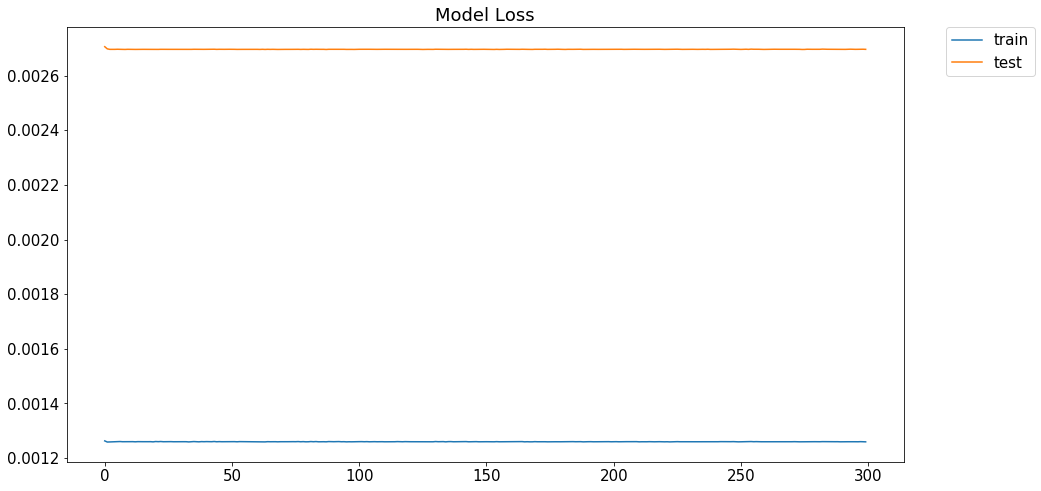

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.legend(['train', 'test'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [72]:
test_dates=np.array(y2.index)[train_size:len(y2)-1]
test_dates[:10]

array(['2014-09-12T00:00:00.000000000', '2014-09-13T00:00:00.000000000',
       '2014-09-14T00:00:00.000000000', '2014-09-15T00:00:00.000000000',
       '2014-09-16T00:00:00.000000000', '2014-09-17T00:00:00.000000000',
       '2014-09-18T00:00:00.000000000', '2014-09-19T00:00:00.000000000',
       '2014-09-20T00:00:00.000000000', '2014-09-21T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [73]:
len(pd.to_datetime(test_dates).to_pydatetime())

1570

In [0]:
# make a prediction
yhat = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))

In [75]:
# Invert scaling for forecast
inv_yhat = concatenate((yhat, testX[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Invert scaling for actual
testY = testY.reshape((len(testY), 1))
inv_y = concatenate((testY, testX[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)

RMSE: 39.720


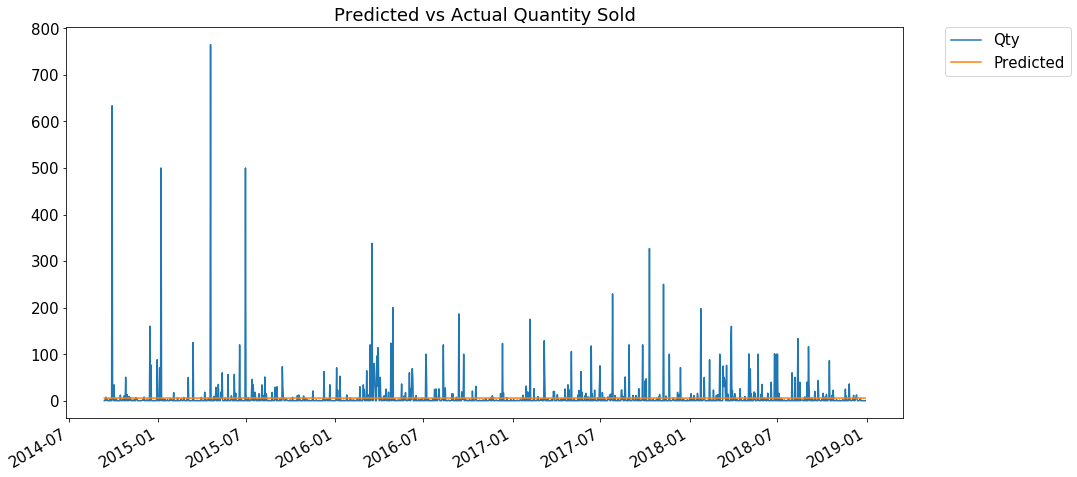

In [76]:
# Plot predictions
fig, ax = plt.subplots(1)
ax.plot(pd.to_datetime(test_dates).to_pydatetime(),inv_y, label="Qty",zorder=1)
ax.plot(pd.to_datetime(test_dates).to_pydatetime(),inv_yhat,label="Predicted",zorder=2)
fig.autofmt_xdate()
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title('Predicted vs Actual Quantity Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

If a NN is having trouble learning, they'll just learn to output the average output value, regardless of the inputs. 

In [77]:
# We can see that's the case here 
inv_yhat

array([5.681573 , 5.681573 , 5.681573 , ..., 5.681573 , 5.6815724,
       5.6815724], dtype=float32)

## LSTM Model #3: Daily Prediction with Added Features

This time, we will attempt to predict daily quantities of sales versus montly  averages, including other variables as features. 

In [148]:
df_lstm2 = df_sup.copy()
df_lstm2.head()

Type       Date Name_State                 Name  \
567  Invoice 1997-09-23         GA  7424213167371143288   
538  Invoice 1997-09-23         GA  7424213167371143288   
557  Invoice 1997-09-23         GA  7424213167371143288   
519  Invoice 1997-09-23         GA  7424213167371143288   
548  Invoice 1997-09-23         GA  7424213167371143288   

                                                  Item          Account  \
567        71438 (InternetWk/TCP-IP - 4 - Single User)  Sales Technical   
538        71435 (InternetWk/TCP-IP - 1 - Single User)  Sales Technical   
557        71437 (InternetWk/TCP-IP - 3 - Single User)  Sales Technical   
519  71419 (Enterprise Series - Instal/Config - 1- ...  Sales Technical   
548         71436 (InternetWk/TCP-IP - 2- Single User)  Sales Technical   

                Class Rep  Qty  Sales_Price  Amount  Balance Account_Type  
567  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1439.70       Income  
538  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1439.70       Income  
557  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1439.70       Income  
519  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1589.65       Income  
548  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1439.70       Income

In [149]:
le = preprocessing.LabelEncoder()
df_lstm2['Type'] = le.fit_transform(df_lstm2['Type'])
df_lstm2['Name_State'] = le.fit_transform(df_lstm2['Name_State'])
df_lstm2['Item'] = le.fit_transform(df_lstm2['Item'])
df_lstm2['Account'] = le.fit_transform(df_lstm2['Account'])
df_lstm2['Class'] = le.fit_transform(df_lstm2['Class'])
df_lstm2['Rep'] = le.fit_transform(df_lstm2['Rep'])
df_lstm2['Account_Type'] = le.fit_transform(df_lstm2['Account_Type'])
df_lstm2 = df_lstm2.drop(['Name'], axis=1)
df_lstm2.head()

Type       Date  Name_State  Item  Account  Class  Rep  Qty  Sales_Price  \
567     0 1997-09-23          10    56        5      8   12  5.0       287.94   
538     0 1997-09-23          10    52        5      8   12  5.0       287.94   
557     0 1997-09-23          10    55        5      8   12  5.0       287.94   
519     0 1997-09-23          10    50        5      8   12  5.0       287.94   
548     0 1997-09-23          10    54        5      8   12  5.0       287.94   

     Amount  Balance  Account_Type  
567  1439.7  1439.70             1  
538  1439.7  1439.70             1  
557  1439.7  1439.70             1  
519  1439.7  1589.65             1  
548  1439.7  1439.70             1

In [150]:
df_lstm2['Date']=pd.to_datetime(df_lstm2['Date'])
df_lstm2.sort_values(by=['Date'], inplace=True, ascending=True)
df_lstm2.index = df_lstm2.Date 
df_lstm2.head(10)

Type       Date  Name_State  Item  Account  Class  Rep  Qty  \
Date                                                                      
1997-09-23     0 1997-09-23          10    56        5      8   12  5.0   
1997-09-23     0 1997-09-23          10    42        5      8   12  5.0   
1997-09-23     0 1997-09-23          10    37        0      8   12  5.0   
1997-09-23     0 1997-09-23          10    40        5      8   12  5.0   
1997-09-23     0 1997-09-23          10    39        0      8   12  5.0   
1997-09-23     0 1997-09-23          10    44        5      8   12  5.0   
1997-09-23     0 1997-09-23          10    48        5      8   12  5.0   
1997-09-23     0 1997-09-23          10    47        5      8   12  5.0   
1997-09-23     0 1997-09-23          10    43        5      8   12  5.0   
1997-09-23     0 1997-09-23          10    49        5      8   12  5.0   

            Sales_Price  Amount  Balance  Account_Type  
Date                                                    
1997-09-23       287.94  1439.7  1439.70             1  
1997-09-23       287.94  1439.7  1589.65             1  
1997-09-23       287.94  1439.7  3714.60             1  
1997-09-23       287.94  1439.7  3564.65             1  
1997-09-23       287.94  1439.7  3714.60             1  
1997-09-23       287.94  1439.7  1589.65             1  
1997-09-23       287.94  1439.7  1589.65             1  
1997-09-23       287.94  1439.7  1589.65             1  
1997-09-23       287.94  1439.7  1589.65             1  
1997-09-23       287.94  1439.7  1589.65             1

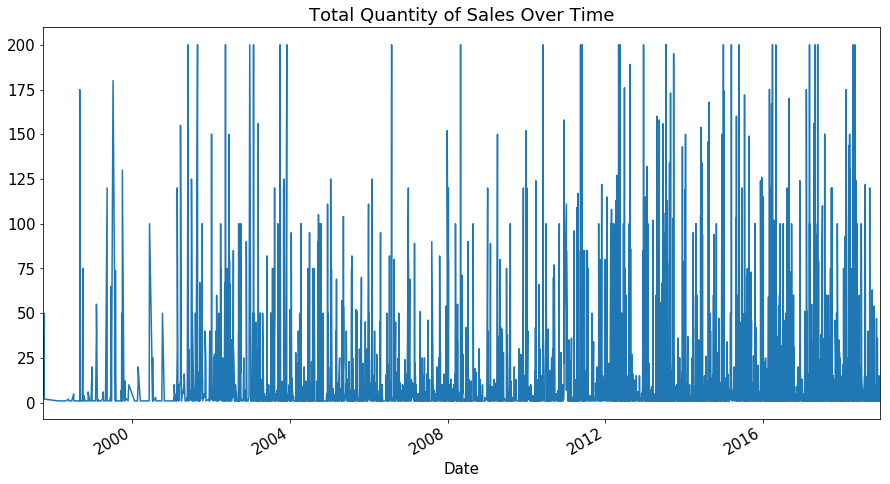

In [133]:
# Visualize the target variable 
df_lstm2['Qty'].plot()
plt.title('Total Quantity of Sales Over Time')
plt.show()

In [0]:
# Create variable for previous days quantity 
df_lstm2['Qty(t+1)']=df_lstm2['Qty'].shift(-1)
df_lstm2.drop(df_lstm2.tail(1).index,inplace=True)

In [104]:
# We will not include amount considering we wouldn't have this bit of information without knowing the quantity sold 
scaler = MinMaxScaler()
X= scaler.fit_transform(df_lstm2[['Qty', 'Sales_Price','Name_State','Item','Account','Class','Rep','Qty','Sales_Price','Account_Type']])#balance 
y=scaler.fit_transform(df_lstm2[['Qty(t+1)']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [105]:
# Reserving 20% for the test set 
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]
print(len(train_X), len(test_X))
print(len(train_y),len(test_y))

5646 1412
5646 1412


In [106]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5646, 1, 10) (5646, 1) (1412, 1, 10) (1412, 1)


In [107]:
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
# Second LSTM layer



model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
history = model.fit(train_X, train_y,epochs=50,batch_size=32,validation_data=(test_X, test_y),verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


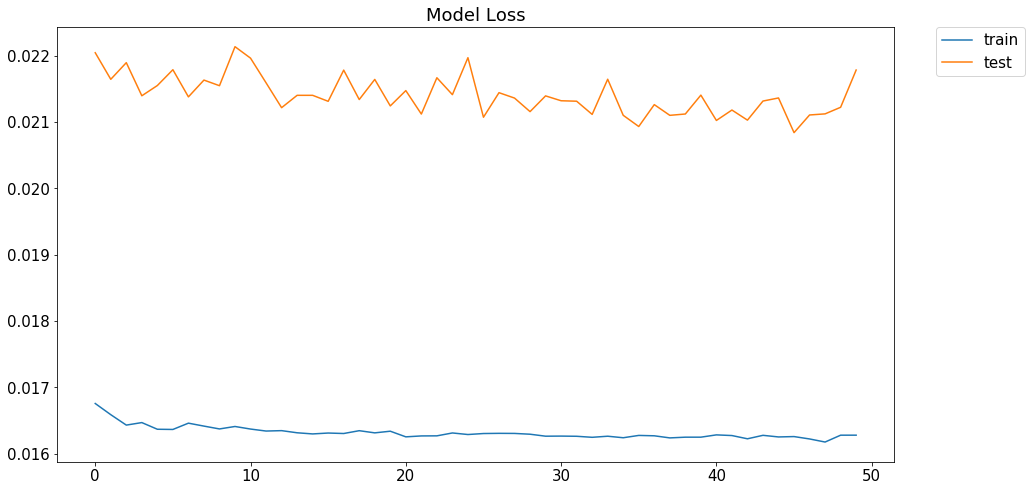

In [108]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [110]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 29.372


In [111]:
from datetime import datetime
test_dates=np.array(df_lstm2.index)[train_size:len(y)]
test_dates[:10]

array(['2016-03-22T00:00:00.000000000', '2016-03-22T00:00:00.000000000',
       '2016-03-22T00:00:00.000000000', '2016-03-22T00:00:00.000000000',
       '2016-03-22T00:00:00.000000000', '2016-03-22T00:00:00.000000000',
       '2016-03-22T00:00:00.000000000', '2016-03-22T00:00:00.000000000',
       '2016-03-22T00:00:00.000000000', '2016-03-22T00:00:00.000000000'],
      dtype='datetime64[ns]')

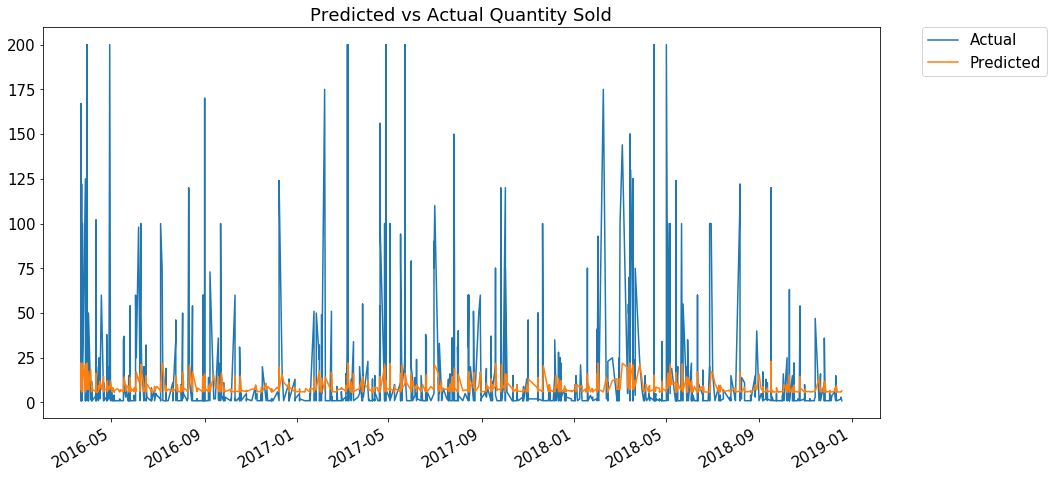

In [112]:
# Plot predictions
fig, ax = plt.subplots(1)
ax.plot(pd.to_datetime(test_dates).to_pydatetime(),inv_y, label="Actual",zorder=1)
ax.plot(pd.to_datetime(test_dates).to_pydatetime(),inv_yhat,label="Predicted",zorder=2)

fig.autofmt_xdate()
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title('Predicted vs Actual Quantity Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Considering we are now predicting daily sales quantities, it doesn't seem too awful. Though, our SARIMAX daily quantity predictions RMSE was much less, it didnt' follow the spikes in sales quite as well as our LSTM model appears to be doing. 

# Supervised Learning 

## Extreme Boosting Model

In [181]:
df_gbm = df_sup.copy()
df_gbm.head()

Type       Date Name_State                 Name  \
567  Invoice 1997-09-23         GA  7424213167371143288   
538  Invoice 1997-09-23         GA  7424213167371143288   
557  Invoice 1997-09-23         GA  7424213167371143288   
519  Invoice 1997-09-23         GA  7424213167371143288   
548  Invoice 1997-09-23         GA  7424213167371143288   

                                                  Item          Account  \
567        71438 (InternetWk/TCP-IP - 4 - Single User)  Sales Technical   
538        71435 (InternetWk/TCP-IP - 1 - Single User)  Sales Technical   
557        71437 (InternetWk/TCP-IP - 3 - Single User)  Sales Technical   
519  71419 (Enterprise Series - Instal/Config - 1- ...  Sales Technical   
548         71436 (InternetWk/TCP-IP - 2- Single User)  Sales Technical   

                Class Rep  Qty  Sales_Price  Amount  Balance Account_Type  
567  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1439.70       Income  
538  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1439.70       Income  
557  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1439.70       Income  
519  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1589.65       Income  
548  Federal Gov.:DoD  SF  5.0       287.94  1439.7  1439.70       Income

In [182]:
le = preprocessing.LabelEncoder()
df_gbm['Type'] = le.fit_transform(df_gbm['Type'])
df_gbm['Name_State'] = le.fit_transform(df_gbm['Name_State'])
df_gbm['Item'] = le.fit_transform(df_gbm['Item'])
df_gbm['Account'] = le.fit_transform(df_gbm['Account'])
df_gbm['Class'] = le.fit_transform(df_gbm['Class'])
df_gbm['Rep'] = le.fit_transform(df_gbm['Rep'])
df_gbm['Account_Type'] = le.fit_transform(df_gbm['Account_Type'])
df_gbm = df_gbm.drop(['Name'], axis=1)
df_gbm.head()

Type       Date  Name_State  Item  Account  Class  Rep  Qty  Sales_Price  \
567     0 1997-09-23          10    56        5      8   12  5.0       287.94   
538     0 1997-09-23          10    52        5      8   12  5.0       287.94   
557     0 1997-09-23          10    55        5      8   12  5.0       287.94   
519     0 1997-09-23          10    50        5      8   12  5.0       287.94   
548     0 1997-09-23          10    54        5      8   12  5.0       287.94   

     Amount  Balance  Account_Type  
567  1439.7  1439.70             1  
538  1439.7  1439.70             1  
557  1439.7  1439.70             1  
519  1439.7  1589.65             1  
548  1439.7  1439.70             1

In [0]:
df_gbm['year'] = pd.DatetimeIndex(df_gbm['Date']).year
df_gbm['month'] = pd.DatetimeIndex(df_gbm['Date']).month
df_gbm['day'] = pd.DatetimeIndex(df_gbm['Date']).day
df_gbm['previous_days_qty'] = df_gbm['Qty'].shift(1)
df_gbm = df_gbm.drop(['Date'], axis =1)

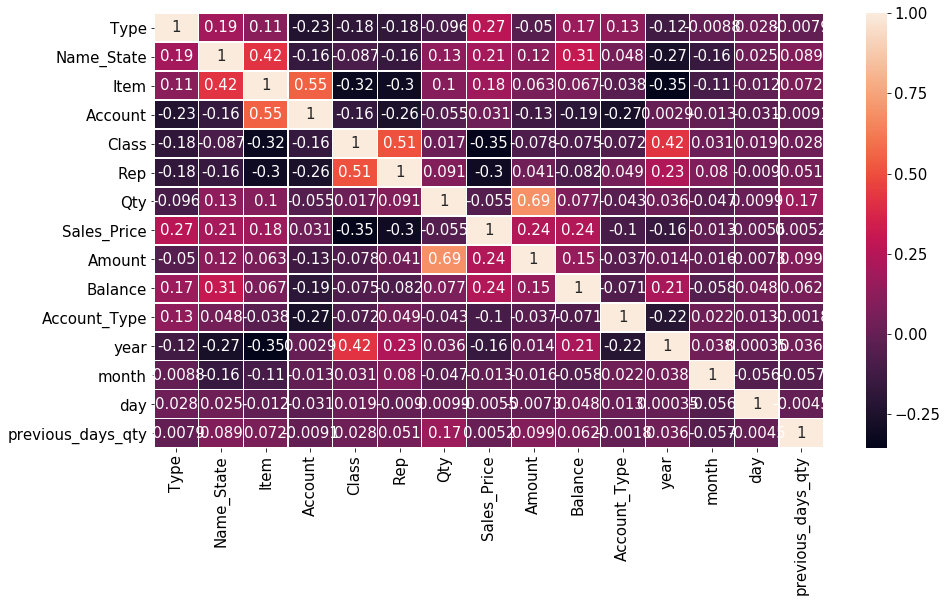

In [184]:
# Correlation matrix 
sns.heatmap(df_gbm.corr(),linewidths=0.1, vmax=1.0,annot=True)
plt.show()

In [0]:
# Create target variable 
# Drop out Amount as well as Balance, as we couldn't have those without already having quantity 
X = df_gbm.drop(['Qty','Amount','Balance'], axis=1)
y = df_gbm.Qty

# Split out training/test data 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle = False, stratify = None)

In [186]:
# Setup regressor
xgb_model = xgb.XGBRegressor()

# Perform a grid search
tweaked_model = GridSearchCV(
    xgb_model,
    {
        'max_depth': [1, 2, 5, 10, 20],
        'n_estimators': [20, 30, 50, 70, 100],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    cv=10,
    verbose=1,
    n_jobs=-1,
    scoring='neg_median_absolute_error'
)

tweaked_model.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (tweaked_model.best_score_, tweaked_model.best_params_))

Fitting 10 folds for each of 125 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 519 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 869 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  8.0min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Best: -3.735765 using {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 20}


In [187]:
# Initiate tweaked model 
tweaked_model = xgb.XGBRegressor(
        max_depth= 20,
        n_estimators= 20,
        learning_rate= 0.1)
tweaked_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [188]:
# Initiate tweaked model 
tweaked_model_final = xgb.XGBRegressor(
        max_depth= 20,
        n_estimators= 20,
        learning_rate= 0.1)
tweaked_model_final.fit(X,y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [189]:
print(tweaked_model.score(X_test, y_test))

-0.03947140339616961


In [0]:
y_pred = tweaked_model.predict(X_test)

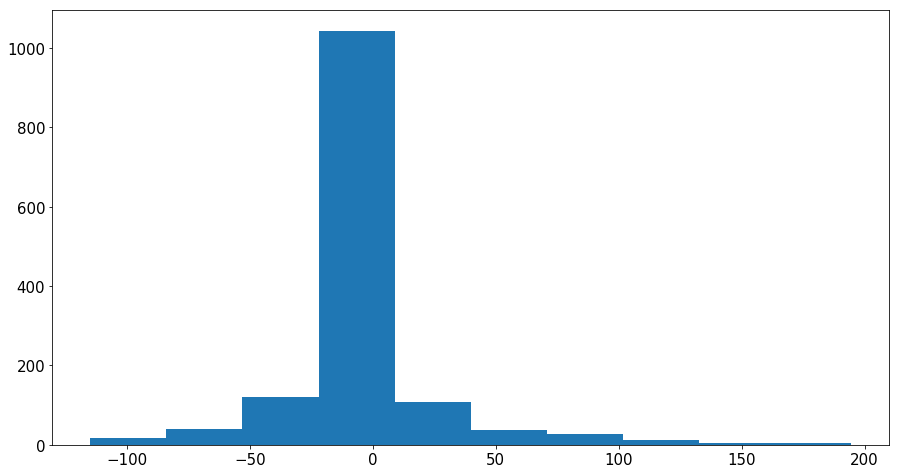

In [191]:
residual = y_test - y_pred
plt.hist(residual)
plt.show()

In [192]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 29.910


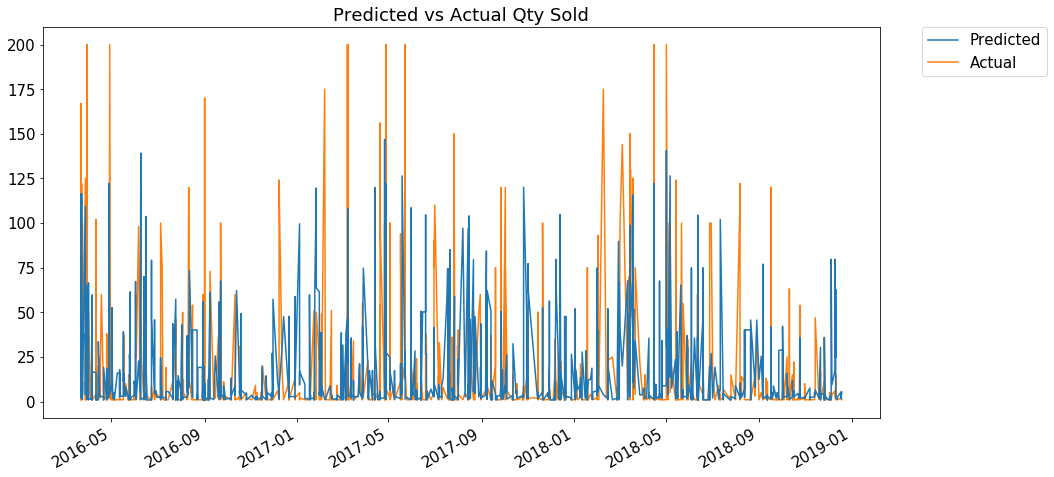

In [193]:
# Plot predictions
fig, ax = plt.subplots(1)
ax.plot(pd.to_datetime(test_dates).to_pydatetime(),y_pred[:-1],label="Predicted",zorder=2)
ax.plot(pd.to_datetime(test_dates).to_pydatetime(),inv_y, label="Actual",zorder=1)
fig.autofmt_xdate()
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title('Predicted vs Actual Qty Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Feature Importance

In [194]:
shap.initjs()
explainer = shap.TreeExplainer(tweaked_model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Below we will simply stack to visualize it in it's entirety. 

In [195]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)
#plt save? 

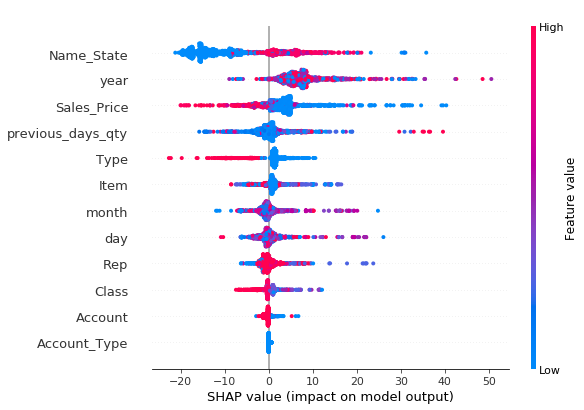

In [196]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

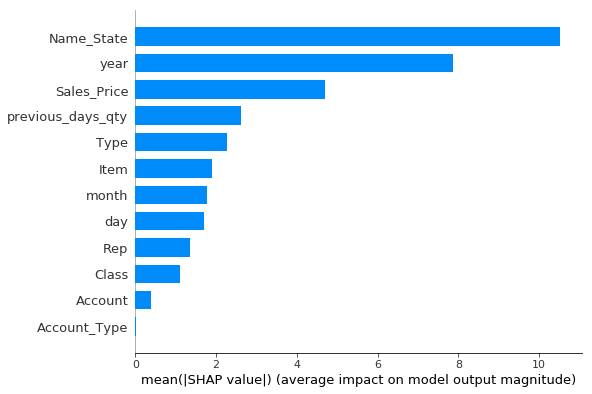

In [197]:
#mean absolute value of the SHAP values for each feature
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Final Outcomes

* Monthly SARIMAX Prediction: Test RMSE: 3.798
* Daily SARIMAX Prediction: Test RMSE: 3.392 
* Monthly LSTM Prediction: Test RMSE: 15.835
* Daily LSTM Prediction: Test RMSE: 39.720 
* Daily LSTM Prediction with Added Features: Test RMSE: 28.753
* Implementation of Gradient Boosted Decision Tree: Test RMSE: 29.910

## Interpretations and Limitations
Now, our monthly SARIMAX prediction is not so bad, you can tell from it's movement it's really trying to follow along the trends and capture spikes. Our daily SARIMAX prediction, not so much. It seems our model essentially fits to the average daily sales trend give or take a few sales quanitites, and that's not quite what we're looking for.

The montly LSTM model doesnt quite stack up to our SARIMAX model, and this is likely due to the smaller amount of data that's fed into the network, and LSTM models generally perform better with more data. What's curious, is in feeding the daily aggregated data to the LSTM model, we generate a series of predictions of the average output variable, despite the input. Perhaps with more architectural changes we could combat this. 

In our next two series of predictions, in incorporating these known feature's, we're asking a new question; *can we predict the quantity sold in a given transaction?* Rather than our initial research question of *can we predict futures sales?* It should also be noted that in using excess features, we have 7,061 observations to work with versus the 8,270 observations available for the time seriers modeling, considering dropped null values. 

That being said, our LSTM multi-featured model has a slightly smaller RMSE than our Extreme Boost model, and appears to follow the trend ofp spikes in quantity sold, but maybe not quite to their full extent. Our Extreme Boosting Model, though a very slightly higher RMSE than that of the LSTM model, seems to capture the spikes in some places, but not so much in others. We must remember here that RMSE does penalize larger errors, so in the predicament where our XGB model predicts a surge in the quantity sold in a sale, that will be penalized more over the LSTM showcasing smaller spikes in a sale. 

## Further Explorations 

I would like to attempt to ncorporate more lagged features for the RNN and GBM; for example the previous 3 and 7 day quantity rolling average, alongside lagged features for other variables besides just the target. 

I'd also like to test out further architectures on the LSTM models used considering our daily predictions didn't quite learn as anticipated. While on the topic of LSTM models, perhaps attempting to incorporate walk forward validation to the LSTM model would help it's learning rate. 